# Bias Correction of Climate Model Output

{bdg-link-info}`Paper (Chapter 4) <https://eprints.lancs.ac.uk/id/eprint/222620/1/2024jeremycarterphd.pdf>`
{bdg-link-info}`Code Repository (Branch jupyterbook_render) <https://github.com/Jez-Carter/Bias_Correction_Application/tree/jupyterbook_render>`

````{card} Challenge:
Climate models are highly-complex and highly-multidimensional. They typically observe a non-insignificant bias in particular variables of interest. In-situ measurements of variables can be used to help apply a bias correction. Where the in-situ measurements are sparse it's important to consider uncertainty, depending on factors such as the underlying spatial covariance between points. 
````

````{card} Approach:
Gaussian processes are used to explicitly model spatial covariance between points and to estimate uncertainties when applying bias correction across the whole domain. A Bayesian hierarchical model is constructed to promote uncertainty propagation across the different components of the model. 
````

```{admonition} Statistical Concepts:
:class: note, dropdown
Gaussian processes represent probability distributions over a function of values by considering the covariance between points. For example, consider some spatial surface of mean temperature over a region. The values will vary smoothly over the domain and so values of nearby points are spatially correlated. To interpolate across the surface and to express what the likelihood is of the particular surface of values observed you need to consider the spatial correlation. This is what Gaussian processes do by parameterising the covariance as a function of distance between points. Since Gaussian processes represent a probability distribution over the function you can estimate an expectation and also uncertainty in predictions.   
```

```{admonition} Generalisability:
:class: note, dropdown
Gaussian processes are highly generalisable as they don't assume a fixed functional form of the underlying process. That is many different types of spatial and/or temporal surfaces can be modelled adequately through them, including oscillatory functions for example. They are applicable across domains such as regression, classification, time-series modelling and spatial analysis. Gaussian processes are also highly interpretable and resistant to overfitting due to being defined by a limited number of hyper-parameters. Finally, providing a probabilistic approach, they also capture uncertainty in estimates, important for various real-world applications and data science pipelines leading to decision-making. The specific example in this notebook is generalisable to any scenario involving combining multiple spatio-temporal datasets, particularly when a good-coverage biased dataset is combined with a poor-coverage unbiased dataset. 
```

```{contents}
:local:
```
<!-- https://jupyterbook.org/en/stable/structure/configure.html -->

## Introduction

This notebook demonstrates an approach to bias correction that utilises Gaussian Processes (GPs) and a Bayesian hierarchical framework. The method is applied to bias correcting temperature data from a climate model over Antarctica using in-situ observations from automatic weather stations. Since the weather stations are both spatially and temporally sparse it's important to capture uncertainty in the correction. Further detail is available at: [J.Carter Thesis (Chapter 4)](https://eprints.lancs.ac.uk/id/eprint/222620/1/2024jeremycarterphd.pdf). The code is in ongoing development and is available at: [Bias Correction Application](https://github.com/Jez-Carter/Bias_Correction_Application.git). The datasets and modules needed to run this notebook are available via the [jupterbook_render branch](https://github.com/Jez-Carter/Bias_Correction_Application/tree/jupyterbook_render) of the repository. 

## Importing Required Libraries and Loading Data

The data for this tutorial is stored as NetCDF files. This is a common file format for climate model output and is handled well by the Xarray Python package, which can be thought of as a Pandas equivalent for efficient handling of multidimensional data. Xarray loads data as 'datasets' and 'dataarrays'. The model in this tutorial is defined using the Python packages Numpyro and TinyGP, which are compatible. Numpyro provides an intuitive probabilistic programming language for Bayesian statistics, built ontop of JAX and with NumPy based syntax. TinyGP provides a lightweight and intuitive package for working with Gaussian Process objects.

In [1]:
# Importing libraries
import pickle 
import timeit
from tqdm import tqdm
import numpy as np
import xarray as xr
import pandas as pd
from scipy.spatial import distance
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from tinygp import kernels, GaussianProcess
from tinygp.kernels.distance import L2Distance
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

rng_key = jax.random.PRNGKey(1)
jax.config.update("jax_enable_x64", True)

/home/jez/miniconda3/envs/jbook_BCA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Data
data_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/'

ds_aws = xr.open_dataset(f'{data_path}ds_aws.nc') # Automatic Weather Station Data
ds_climate = xr.open_dataset(f'{data_path}ds_climate.nc') # Climate Model Data

Using Xarray datasets provides nice interactive tables of the multidimensional data:

In [3]:
# Displaying the AWS data
ds_aws 

<xarray.Dataset> Size: 925kB
Dimensions:         (station: 219, t: 504)
Coordinates:
  * station         (station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws16' 'aws17'
    glat            (station) float64 2kB ...
    glon            (station) float64 2kB ...
    grid_latitude   (station) float64 2kB ...
    grid_longitude  (station) float64 2kB ...
    year            (t) float64 4kB ...
    month           (t) float64 4kB ...
  * t               (t) float64 4kB 1.0 2.0 3.0 4.0 ... 501.0 502.0 503.0 504.0
Data variables:
    latitude        (station) float64 2kB ...
    elevation       (station) float64 2kB ...
    temperature     (station, t) float64 883kB ...

In [4]:
# Displaying the climate model data
ds_climate

<xarray.Dataset> Size: 45MB
Dimensions:         (time: 456, grid_longitude: 126, grid_latitude: 98)
Coordinates:
  * grid_longitude  (grid_longitude) float64 1kB 152.4 152.9 ... 207.0 207.4
  * grid_latitude   (grid_latitude) float64 784B -21.39 -20.95 ... 20.84 21.29
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB ...
    year            (time) int64 4kB ...
    glon            (grid_longitude, grid_latitude) float64 99kB ...
    glat            (grid_longitude, grid_latitude) float64 99kB ...
    t               (time) int64 4kB ...
Data variables:
    temperature     (time, grid_longitude, grid_latitude) float64 45MB ...
    elevation       (grid_longitude, grid_latitude) float64 99kB ...
    latitude        (grid_longitude, grid_latitude) float64 99kB ...

In [5]:
# Computing basic summary statistics using the pandas port of xarray objects
print('Summary of Automatic Weather Station Data \n',
      ds_aws.to_dataframe().describe()[['elevation','latitude','temperature']])
print('\n Summary of Climate Model Data \n',
      ds_climate.to_dataframe().describe()[['elevation','latitude','temperature']])

Summary of Automatic Weather Station Data 
            elevation       latitude   temperature
count  110376.000000  110376.000000  18088.000000
mean     1251.009132     -76.472009    -25.852952
std      1131.183380       5.411963     14.071861
min         5.000000     -90.000000    -71.740000
25%        87.000000     -79.820000    -31.880000
50%      1122.000000     -76.320000    -24.135000
75%      2090.000000     -73.080000    -16.320000
max      4093.000000     -65.240000      1.750000

 Summary of Climate Model Data 
           elevation      latitude   temperature
count  2.610144e+06  2.610144e+06  2.610144e+06
mean   2.003590e+03 -7.661032e+01 -3.257423e+01
std    1.150357e+03  5.392458e+00  1.458319e+01
min   -3.087963e+00 -8.971554e+01 -7.326862e+01
25%    1.045115e+03 -8.060204e+01 -4.373946e+01
50%    2.192235e+03 -7.646343e+01 -3.125523e+01
75%    2.988649e+03 -7.229835e+01 -2.182017e+01
max    4.063502e+03 -6.397399e+01  1.437534e+00


## Data Exploration

Initial data exploration is essential for informing our model construction. It includes examining the spatial and temporal distributions of the data and relationships between variables and potential predictors. To start we'll examine the spatial distribution of weather stations, plotting over the grid of the climate model.

### Spatial Distribution of Weather Stations

```{admonition} Coordinate Systems:
:class: note, dropdown
Note that for plotting we use a specific rotated coordinate system (defined below). The 'glon' and 'glat' fields are in this coordinate system and it was created to get around issues assoicated with plotting the shapefile when the longitude flips between -180 to 180.   
```

ERROR 1: PROJ: proj_create_from_database: Open of /home/jez/miniconda3/envs/jbook_BCA/share/proj failed


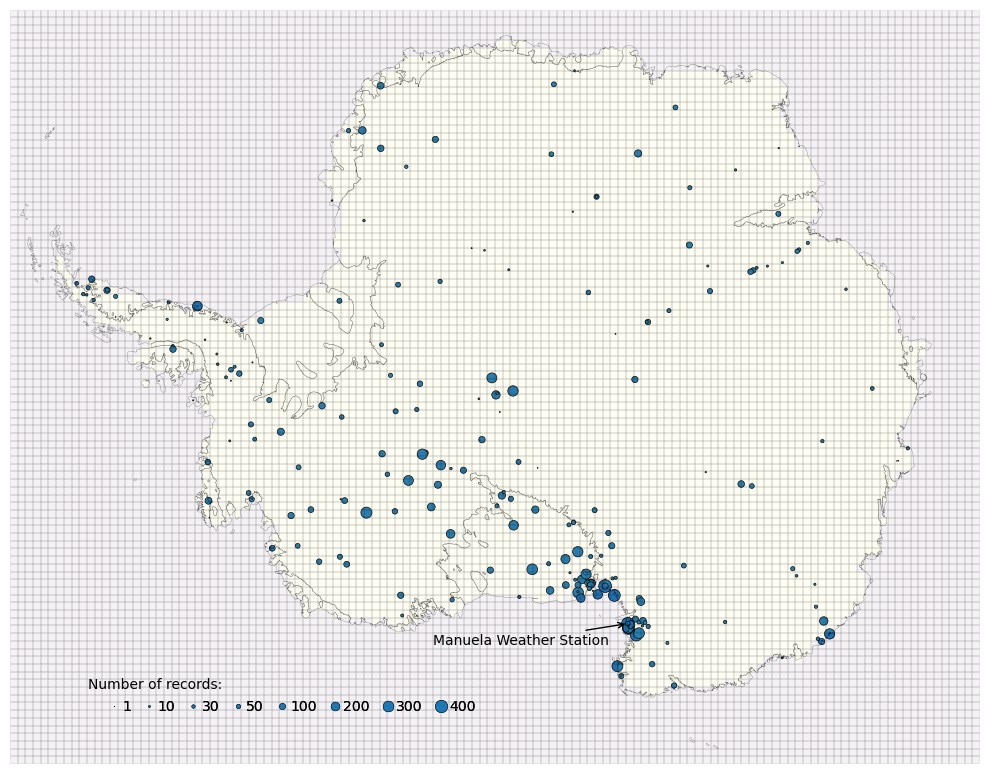

In [6]:
# Loading ice sheet shapefile 
icesheet_shapefile_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/icesheet_shapefile/icesheet.shp'
gdf_icesheet = gpd.read_file(icesheet_shapefile_path)

# Defining rotated coordinate system (glon,glat) and converting ice sheet shapefile to rotated coordinates
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
gdf_icesheet_rotatedcoords = gdf_icesheet.to_crs(rotated_coord_system)

############################################################################################################

# Defining background map function
def background_map_rotatedcoords(ax):
    gdf_icesheet_rotatedcoords.boundary.plot(
        ax=ax,
        color='k',
        linewidth=0.3,
        alpha=0.4)
    ax.set_axis_off()

# Defining marker size legend function
def markersize_legend(ax, bins, scale_multipler, legend_fontsize=10,loc=3,ncols=1,columnspacing=0.8,handletextpad=0.1,bbox=(0.,0.)):
    ax.add_artist(
        ax.legend(
            handles=[
                mlines.Line2D(
                    [],
                    [],
                    color="tab:blue",
                    markeredgecolor="k",
                    markeredgewidth=0.3,
                    lw=0,
                    marker="o",
                    markersize=np.sqrt(b*scale_multipler),
                    label=str(int(b)),
                )
                for i, b in enumerate(bins)
            ],
            loc=loc,
            fontsize = legend_fontsize,
            ncols=ncols,
            columnspacing=columnspacing,
            handletextpad=handletextpad,
            bbox_to_anchor=bbox,
            framealpha=0,
        )
    )

############################################################################################################

# Plotting the weather station locations
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=100)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_aws.glon,
    ds_aws.glat,
    s=ds_aws.count('t')['temperature']/5,
    edgecolor='k',
    linewidths=0.5,
)
ax.annotate(
    'Number of records:',
    xy=(0.08, 0.1), xycoords='axes fraction',
    fontsize=10)
markersize_legend(ax, [1,10,30,50,100,200,300,400], scale_multipler=1/5, legend_fontsize=10,loc=3,ncols=9,columnspacing=0.3,handletextpad=-0.4,bbox=(0.08,0.05))

# highlighting individual station
station = 'Manuela'
ax.annotate(
    f'{station} Weather Station',
    xy=(ds_aws.sel(station = station).glon, ds_aws.sel(station = station).glat), xycoords='data',
    xytext=(-140,-15), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"),
    fontsize=10)

# Plotting the climate model grid
ds_climate['temperature'].mean('time').notnull().plot.pcolormesh(
    x='glon',
    y='glat',
    ax=ax,
    alpha=0.05,
    add_colorbar=False,
    edgecolor='k',
    linewidth=0.3,
)

plt.tight_layout()
plt.show()


It is clear that the spatial distribution of weather stations is not uniform over the domain. There are certain regions containing high-density clusters of stations. This will induce a bias in the bias-correction itself when conducted over the whole domain, with corrections skewed towards these regions. If these clusters occured randomly then modelling the spatial correlation between sites would be adequate to account for the distribution. Instead it is likely these regions were chosen for specific features, such as having anomalously high temperatures, which is difficult to account for in the model. We don't directly attempt to solve this problem but it is noted as a remaining limitation. 

### Time Series and Distribution of Single Weather Station (Manuela)

Comparisons are made between the time series for the Manuela weather station and the nearest grid-cell of the climate model output. The time series represents the average temperature for each month and the values are aggregated from hourly measurements of the raw data (preprocessed in this notebook for simplicity).

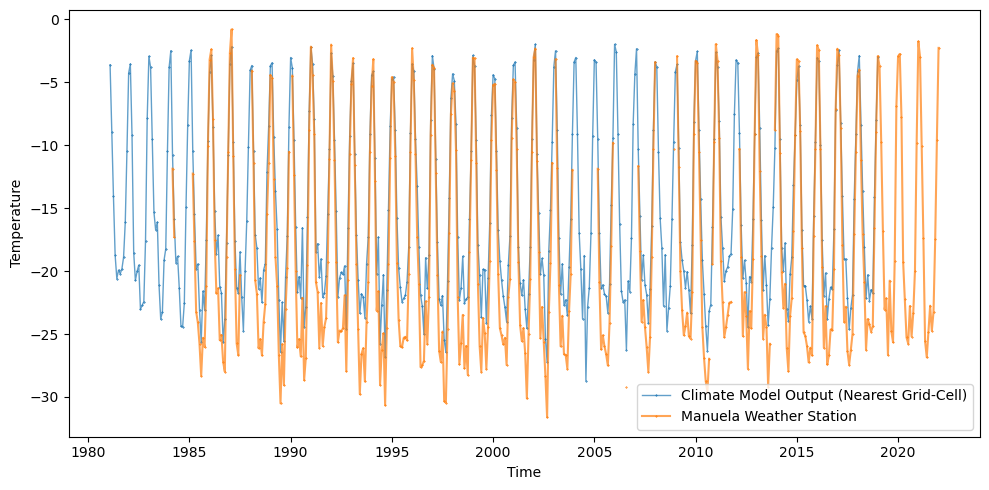

In [7]:
# Computing Nearest Neighbours
ds_climate_stacked = ds_climate.stack(x=('grid_longitude', 'grid_latitude'))
ds_climate_stacked_landonly = ds_climate_stacked.dropna('x')
ox = np.dstack([ds_aws['glon'],ds_aws['glat']])[0]
cx = np.dstack([ds_climate_stacked_landonly['glon'],ds_climate_stacked_landonly['glat']])[0]
nn_indecies = []
for point in ox:
    nn_indecies.append(distance.cdist([point], cx).argmin())
ds_climate_nearest_stacked = ds_climate_stacked_landonly.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})

# Single Site Full Time Series
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
station = 'Manuela'
ds_climate_nearest_stacked.sel(nearest_station = station)['temperature'].plot(x="t",
                                                                              ax=ax,
                                                                              hue='station',
                                                                              alpha=0.7,
                                                                              label='Climate Model Output (Nearest Grid-Cell)',
                                                                              marker='x',
                                                                              ms=1,
                                                                              color='tab:blue',
                                                                              linewidth=1.0)

ds_aws.sel(station = station)['temperature'].plot(ax=ax,
                                                hue='station',
                                                alpha=0.7,
                                                label=f'{station} Weather Station',
                                                marker='x',
                                                ms=1,
                                                color='tab:orange',
                                                linewidth=1.5)
xticks = np.arange(0,45*12,12*5)
xticklabels = np.arange(1980,2025,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend()
ax.set_title('')
plt.tight_layout()
plt.show()


The Manuela weather station has one of the highest number of temperature records, spanning from 1984-2021. The time series for the climate model spans 1981-2019. It's clear that the variance in the time series are dominated by the seasonal cycle and that any bias in for example the mean will have some seasonal dependency. The PDFs for the 2 time series are plot below.

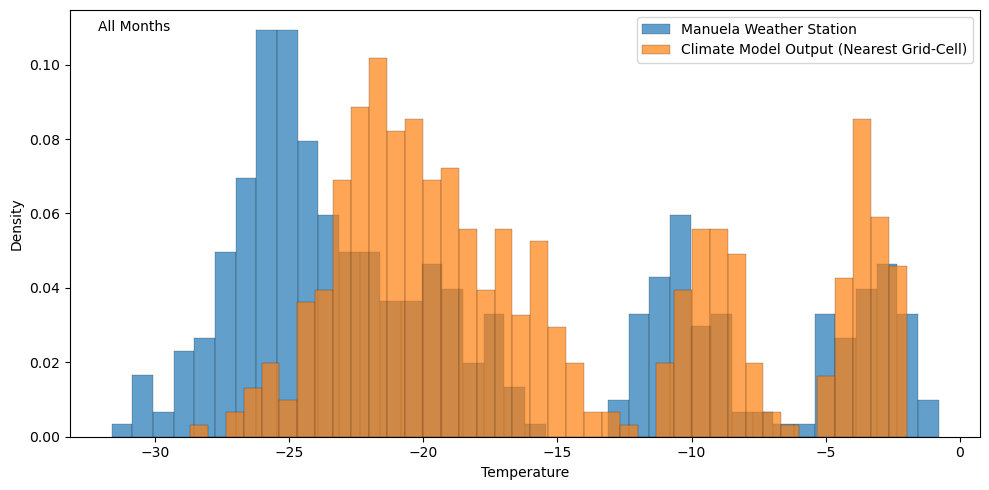

In [8]:
# Probability Density Function (all months)
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ds_aws.sel(station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('All Months',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In this tutorial we define bias with respect to differences between the parameters that describe the PDFs of the time series. The PDF above is multi-modal, reflecting the seasonality of the data, meaning we'd need to use quite a few parameters to adequately describe the distribution. Simply using the mean would have limited value as we can see that the winter peak is ~5° higher for the climate model output while the summer peaks are approximately equal. The common approach here is to simply split the time series up by the month, focusing on defining bias for each month separately. The PDFs for individual months are approximately Gaussian (see below) and so the bias can be defined in terms of differences in the mean and variance parameters between the datasets. 

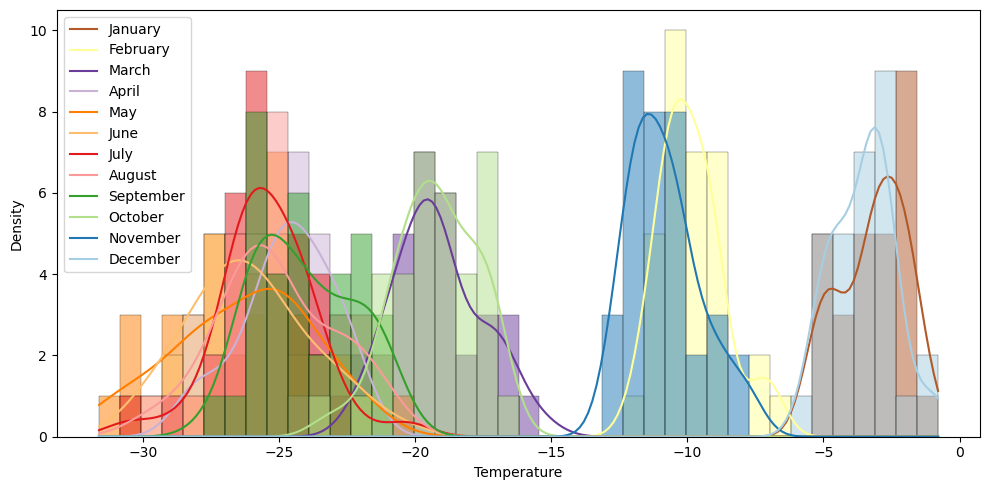

In [9]:
# Probability Density Function by Month
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

sns.histplot(data=ds_aws.sel(station=station).to_dataframe()[['month','temperature']],
            x='temperature',
            hue='month',
            bins=40,
            ax=ax,
            edgecolor='k',
            linewidth=0.2,
            kde=True,
            palette='Paired',
)

ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend(['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.tight_layout()
plt.show()

In this tutorial, we'll focus on just applying bias correction to the monthly June time series, shown below for the Manuela station.

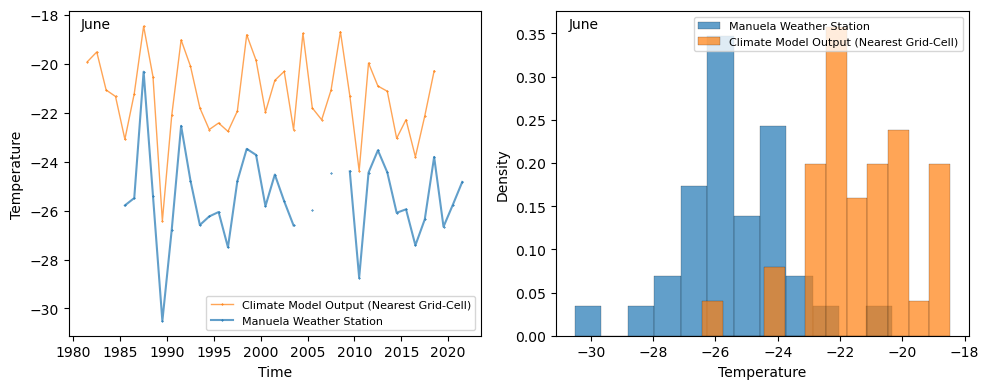

In [10]:
month = 6 
station = 'Manuela'

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
ds_climate_nearest_stacked.sel(nearest_station = station).where(ds_climate_nearest_stacked['month']==month,drop=True)['temperature'].plot(
                                                                                                                                x='t',
                                                                                                                                ax=ax,
                                                                                                                                hue='station',
                                                                                                                                alpha=0.7,
                                                                                                                                label='Climate Model Output (Nearest Grid-Cell)',
                                                                                                                                marker='x',
                                                                                                                                ms=1,
                                                                                                                                color='tab:orange',
                                                                                                                                linewidth=1.0)
ds_aws.sel(station = station).where(ds_aws['month']==month,drop=True)['temperature'].plot(ax=ax,
                                                                                                hue='station',
                                                                                                alpha=0.7,
                                                                                                label=f'{station} Weather Station',
                                                                                                marker='x',
                                                                                                ms=1,
                                                                                                color='tab:blue',
                                                                                                linewidth=1.5)

ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)#,rotation = 90)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend(fontsize=8)
ax.set_title('')

ax=axs[1]
ds_aws.sel(station=station).where(ds_aws['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).where(ds_climate_nearest_stacked['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


When examining the June time series, it's clear that the climate model performs well at capturing the yearly variability and is highly correlated with the weather station output. However, there's a significant bias in the mean of approximately 4°, indicating the utility of applying a bias correction. 

### Pairplots

Since we're interested in evaluating bias in the mean and variance of the June time series, it's useful to think about predictors that have an influence on these metrics. The two most obvious predictors are elevation and latitude, both of which have well-understood physical justification for the impact on the mean temperature. 

```{admonition} Filtering AWS Data:
:class: note, dropdown
We filter to just June records as discussed above and also to only stations with more than 5 records. This limits the influence of uncertainty in the empirical estimates used for exploratory analysis.
```

```{admonition} Nearest Grid Cells:
:class: note, dropdown
We've included a subcategory 'Climate Model Nearest' that represent values for just the climate model grid-cells nearest to each AWS. This is to get a feel for how representative the AWS samples are of Antarctic-wide region (e.g. it might be that differences between the datasets are just the result of the particular sample of locations with weather stations). 
```

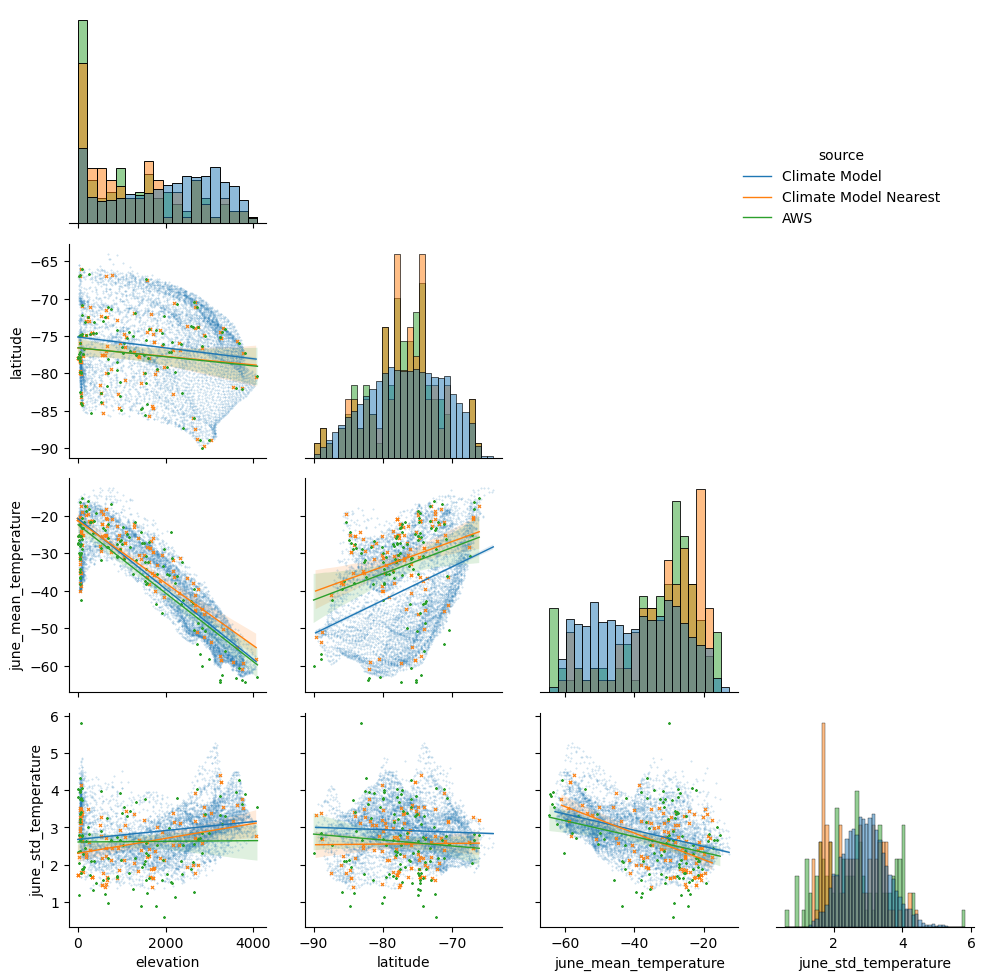

In [11]:
# Filtering to June only
ds_aws_filtered = ds_aws.sel(t = ds_aws.month == 6)
ds_climate_stacked_landonly_filtered = ds_climate_stacked_landonly.sel(time = ds_climate_stacked_landonly.month == 6)
ds_climate_nearest_stacked_filtered = ds_climate_nearest_stacked.sel(time = ds_climate_nearest_stacked.month == 6)

# Filtering AWS by number of records and updating nearest grid-cells to match
ds_aws_filtered['records'] = ds_aws_filtered.count('t')['temperature']
stations_recordsfilter = ds_aws_filtered.where(ds_aws_filtered['records']>5,drop=True)['station'].data

ds_aws_filtered = ds_aws_filtered.sel(station=stations_recordsfilter)
ds_climate_nearest_stacked_filtered = ds_climate_nearest_stacked_filtered.sel(nearest_station=stations_recordsfilter)

# Computing June Mean and Standard Deviation
ds_aws_filtered['june_mean_temperature'] = ds_aws_filtered.mean('t')['temperature']
ds_aws_filtered['june_std_temperature'] = ds_aws_filtered.std('t')['temperature']
ds_climate_stacked_landonly_filtered['june_mean_temperature'] = ds_climate_stacked_landonly_filtered.mean('time')['temperature']
ds_climate_stacked_landonly_filtered['june_std_temperature'] = ds_climate_stacked_landonly_filtered.std('time')['temperature']
ds_climate_nearest_stacked_filtered['june_mean_temperature'] = ds_climate_nearest_stacked_filtered.mean('time')['temperature']
ds_climate_nearest_stacked_filtered['june_std_temperature'] = ds_climate_nearest_stacked_filtered.std('time')['temperature']

# Transforming data for plotting with seaborn PairGrid 
vars = ['elevation','latitude','june_mean_temperature','june_std_temperature']
df_climate_filtered = ds_climate_stacked_landonly_filtered[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate_nearest_filtered = ds_climate_nearest_stacked_filtered[vars].to_dataframe()[vars].reset_index(drop=True)
df_aws_filtered = ds_aws_filtered[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate_filtered['source'] = 'Climate Model'
df_climate_nearest_filtered['source'] = 'Climate Model Nearest'
df_aws_filtered['source'] = 'AWS'
df_combined = pd.concat([df_climate_filtered,df_climate_nearest_filtered,df_aws_filtered],axis=0).reset_index(drop=True)

# Plotting PairGrid with regression lines
g = sns.PairGrid(df_combined, hue='source',diag_sharey=False, corner=True)

reg_kws = {'scatter': False, 'line_kws':{'linewidth':1}}
g.map_lower(sns.regplot,**reg_kws)
g.add_legend(bbox_to_anchor=(0.8,0.8),markerscale=3)

g.hue_kws = {'marker':['+','x','*'],'s':[2,5,2],'alpha':[0.2,1,1]}
scatter_kws = {'linewidth':0.8}
g.map_lower(plt.scatter,**scatter_kws)

hist_kws = {'common_norm':False,'stat':'density'}
g.map_diag(sns.histplot,**hist_kws)

plt.show()

The pairplots bring up some interesting features:
- Comparisons of the histograms between the 'Climate Model' data (all grid-cells over Antarctica) and the 'Climate Model Nearest' data (only grid-cells closest to the weather stations) indicate that the AWS sites are not a particularly representative sample of the whole Antarctic region. There's a higher proportion of sites at zero elevation, clusters of sites at particular locations (and so latitudes), disproportionality high numbers of sites at regions with relatively high mean temperatures and relatively low standard deviations.
- There's clear relationships between mean temperature with elevation and latitude. The slope of the linear relationship does not seem too strongly impacted by the particular subsample of AWS locations. 
- There's only a weak relationship between the standard deviation in temperature with elevation and latitude. As a result we'll leave out these predictors when estimating the standard deviation across the domain. 
- The behaviour of the relationship between elevation with mean temperature appears quite different at zero elevation sites, which could be linked with various factors such as the proximity and impact of the nearby sea on zero elevation sites. This potentially indicates at the utility of incorporating a distance to the coast predictor, although for this tutorial we leave this out.  

### Examining spatial covariance after removing influence of elevation and latitude

The spatial pattern in mean temperature is currently dominated by the relationship with elevation and latitude. While these are clearly important predictors for mean temperature, it's expected that there'll be various other important factors that impact mean temperature but are harder to account for (e.g. the funneling of wind down valleys will impact the mean temperature). One way of at least partially accounting for these factors is to model the spatial covariance between sites after removing the influence of elevation and latitude. That is that nearby sites are likely to be highly correlated as the factors impacting them are similar, whereas the further away you go the less correlated the sites will be (different valleys with different wind patterns etc). 

Here we'll plot the spatial pattern in the mean temperature after removing the linear influence of elevation and latitude. Additionally, we'll plot the spatial pattern in the log of the standard deviation (taking the log to get the metric on the -$\infty,\infty$ domain). Since the relationship between elevation and latitude with standard deviation appeared weak, we'll ignore these predictors for this metric and simply remove a constant to get the zero-mean log(standard deviations). 

In [12]:
# Modelling the linear relationship between elevation, latitude and June mean temperature

# Defining predictors and scaling
predictors = ['elevation','latitude']
scaled_predictors = [i+'_scaled' for i in predictors]
target = 'june_mean_temperature'

scaler = StandardScaler()
df_aws_filtered_scaled_predictors = pd.DataFrame(scaler.fit_transform(df_aws_filtered[predictors]),columns=scaled_predictors)
df_climate_filtered_scaled_predictors = pd.DataFrame(scaler.transform(df_climate_filtered[predictors]),columns=scaled_predictors)

# Linear Regression AWS
print("Linear Regression AWS:")
model = LinearRegression()
model.fit(df_aws_filtered_scaled_predictors,df_aws_filtered[target])
df_aws_filtered['june_mean_temperature_predicted_lr'] = model.predict(df_aws_filtered_scaled_predictors)
feature_importance = pd.Series(model.coef_, index=scaled_predictors)
print('intercept:',model.intercept_)
print(feature_importance.sort_values(ascending=False,key=abs))

# Linear Regression Climate Model
print("\n Linear Regression Climate Model:")
model = LinearRegression()
model.fit(df_climate_filtered_scaled_predictors,df_climate_filtered[target])
df_climate_filtered['june_mean_temperature_predicted_lr'] = model.predict(df_climate_filtered_scaled_predictors)
feature_importance = pd.Series(model.coef_, index=scaled_predictors)
print('intercept:',model.intercept_)
print(feature_importance.sort_values(ascending=False,key=abs))

ds_climate_stacked_landonly_filtered['june_mean_temperature_predicted_lr'] = (
    ('x'),
    df_climate_filtered['june_mean_temperature_predicted_lr'])

ds_aws_filtered['june_mean_temperature_predicted_lr'] = (
    ('station'),
    df_aws_filtered['june_mean_temperature_predicted_lr'])

ds_climate_stacked_landonly_filtered['june_mean_temperature_residual_lr']=ds_climate_stacked_landonly_filtered['june_mean_temperature']-ds_climate_stacked_landonly_filtered['june_mean_temperature_predicted_lr']
ds_aws_filtered['june_mean_temperature_residual_lr']=ds_aws_filtered['june_mean_temperature']-ds_aws_filtered['june_mean_temperature_predicted_lr']

ds_climate_stacked = xr.merge([ds_climate_stacked,ds_climate_stacked_landonly_filtered])


Linear Regression AWS:
intercept: -33.625017170326736
elevation_scaled   -10.160912
latitude_scaled      1.952785
dtype: float64

 Linear Regression Climate Model:
intercept: -33.094520306833495
elevation_scaled   -10.223010
latitude_scaled      2.895803
dtype: float64


In [13]:
# Computing the zero-mean log(standard deviation)
ds_aws_filtered['june_logstd_temperature']=np.log(ds_aws_filtered['june_std_temperature'])
ds_climate_stacked['june_logstd_temperature']=np.log(ds_climate_stacked['june_std_temperature'])
ds_climate_nearest_stacked_filtered['june_logstd_temperature']=np.log(ds_climate_nearest_stacked_filtered['june_std_temperature'])
ds_aws_filtered['june_logstd_temperature_residual_constant'] = ds_aws_filtered['june_logstd_temperature'] - ds_aws_filtered['june_logstd_temperature'].mean()
ds_climate_stacked['june_logstd_temperature_residual_constant'] = ds_climate_stacked['june_logstd_temperature'] - ds_climate_stacked['june_logstd_temperature'].mean()
ds_climate_nearest_stacked_filtered['june_logstd_temperature_residual_constant']=ds_climate_nearest_stacked_filtered['june_logstd_temperature'] - ds_climate_nearest_stacked_filtered['june_logstd_temperature'].mean()


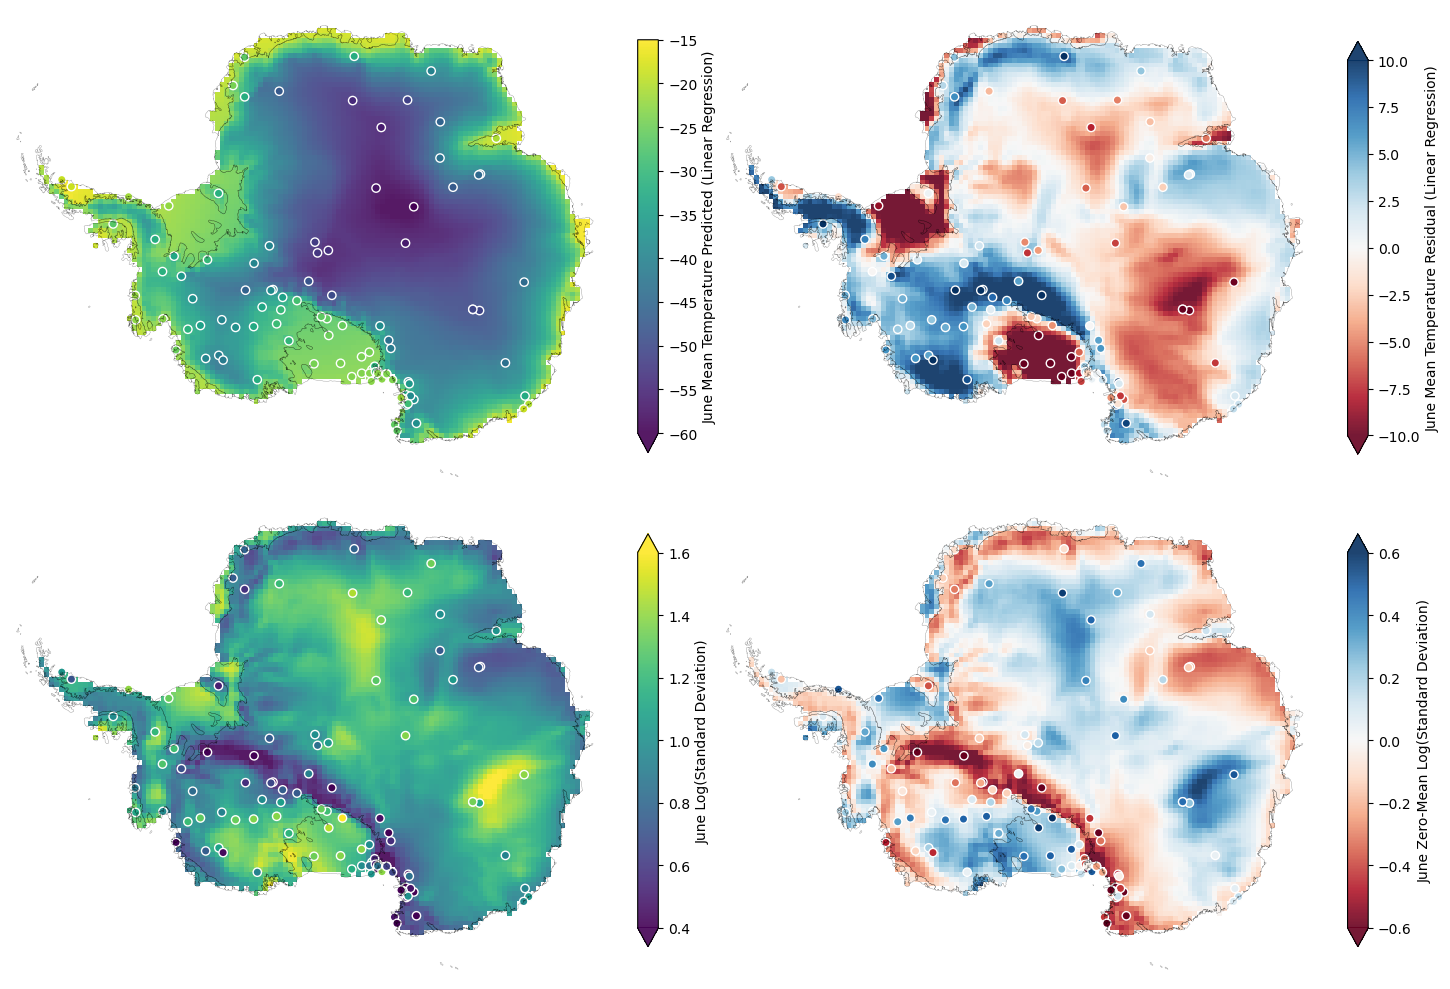

In [14]:
# Plotting the linear regression prediction and residual
fig, axs = plt.subplots(2, 2, figsize=(15, 10),dpi=100)#,frameon=False)

metrics = ['june_mean_temperature_predicted_lr','june_mean_temperature_residual_lr','june_logstd_temperature','june_logstd_temperature_residual_constant']
cmaps = ['viridis','RdBu','viridis','RdBu']
vminmaxs = [(-60,-15),(-10,10),(0.4,1.6),(-0.6,0.6)]
labels = ['June Mean Temperature Predicted (Linear Regression)','June Mean Temperature Residual (Linear Regression)',
          'June Log(Standard Deviation)','June Zero-Mean Log(Standard Deviation)']

for ax,metric,vminmax,cmap,label in zip(axs.ravel(),metrics,vminmaxs,cmaps,labels):
    background_map_rotatedcoords(ax)
    ds_climate_stacked[metric].unstack().plot.pcolormesh(
        x='glon',
        y='glat',
        ax=ax,
        alpha=0.9,
        vmin=vminmax[0],
        vmax=vminmax[1],
        cmap=cmap,
        cbar_kwargs = {'fraction':0.030,
                    'pad':0.02,
                    'label':label}
    )

    ax.scatter(
        ds_aws_filtered['glon'],
        ds_aws_filtered['glat'],
        marker="o",
        c=ds_aws_filtered[metric],
        cmap=cmap,
        edgecolor="w",
        linewidth=1.0,
        vmin=vminmax[0],
        vmax=vminmax[1],
    )

    ax.set_axis_off()
    ax.set_title('')
                       
plt.tight_layout()

It's clear once we remove the linear dependency of temperature with elevation and latitude we get quite a different spatial structure for the mean temperature. This is the spatial structure we'll want to model using Gaussian processes, where the covariance between nearby sites is captured by parameterising the covariance as a function of distance. In our model we'll assume a single length scale for the covariance, that is to say we assume the covariance between nearby sites decays at the same distance wherever you are located over Antarctica. While this assumption is clearly broken in certain areas (e.g. covariance in steep regions near to the coast behaves differently to flat regions inland), it still provides a start and is a lot simpler than the approach of considering non-stationary lengthscales across the region (although this is possible). It's important to consider how this will impact our results and we expect one of the main influences is that the noise term estimated for our Gaussian process will be relatively high to account for the sharp variations between nearby sites in particularly steep regions.  

It's also important to note that the spatial patterns in both the AWS data and climate model data are similar for each metric. That is the climate model is doing a reasonable job at capturing the more complex dependencies of mean temperature and log(standard dev) in temperature. To utilise this, in our model we consider a shared latent Gaussian process between the datasets and so predictions of the unbiased values are made conditioning on both datasets.  

### Examining spatial covariance in the bias

It's also useful to explore the spatial structure of the bias (both in the mean and log(standard deviation) of june temperature). In this exploratory analysis we do this by examining the empirical values of the metrics from the AWS data and the nearest climate model grid-cells. 

For the mean temperature, this is done after accounting for the linear relationship with elevation and latitude (that is we examine the spatial structure in the bias of the residuals). For the log(standard deviation), we examine bias in the zero-meaned values for each dataset. 


In [15]:
# Recomputing nearest neighbours
ds_climate_nearest_stacked = ds_climate_stacked_landonly_filtered.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})
ds_climate_nearest_stacked_filtered = ds_climate_nearest_stacked.sel(nearest_station=stations_recordsfilter)

# Recomputing the zero-mean log(standard deviation)
ds_climate_nearest_stacked_filtered['june_logstd_temperature']=np.log(ds_climate_nearest_stacked_filtered['june_std_temperature'])
ds_climate_nearest_stacked_filtered['june_logstd_temperature_residual_constant']=ds_climate_nearest_stacked_filtered['june_logstd_temperature'] - ds_climate_nearest_stacked_filtered['june_logstd_temperature'].mean()

# Evaluating bias in residuals from linear regression for the mean temperature
ds_climate_nearest_stacked_filtered['bias_june_mean_temperature_residual_lr'] = (
    ('nearest_station'),
    ds_climate_nearest_stacked_filtered['june_mean_temperature_residual_lr'].data - ds_aws_filtered['june_mean_temperature_residual_lr'].data)

# Evaluating bias for the log(std) temperature
ds_climate_nearest_stacked_filtered['bias_june_logstd_temperature_residual_constant'] = (
    ('nearest_station'),
    ds_climate_nearest_stacked_filtered['june_logstd_temperature_residual_constant'].data - ds_aws_filtered['june_logstd_temperature_residual_constant'].data)


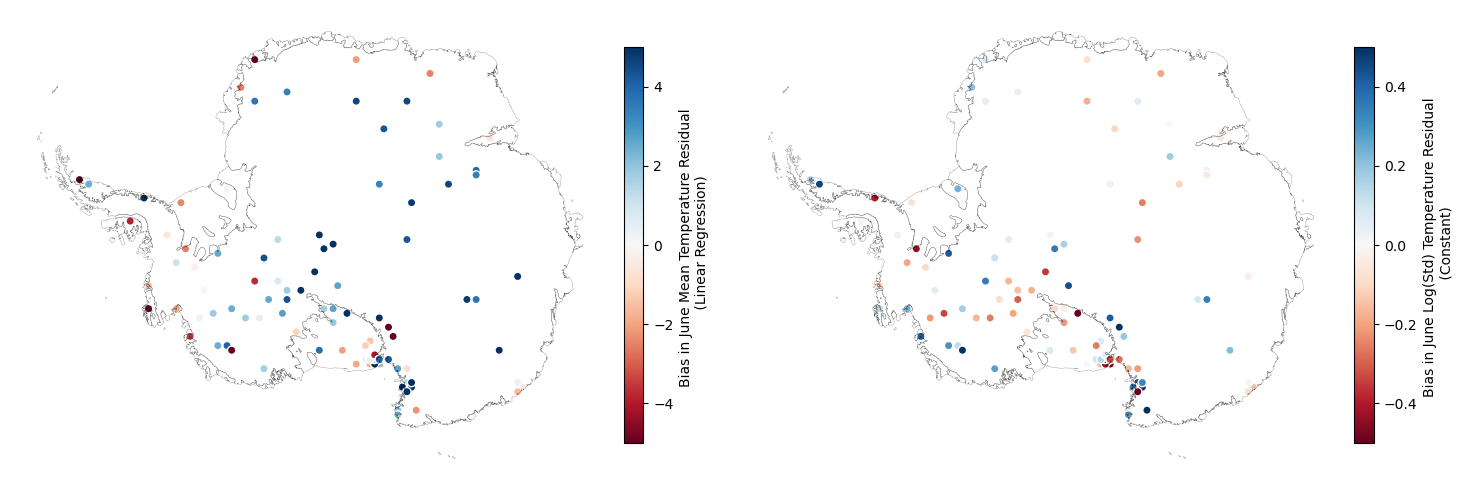

In [16]:
# Plotting the linear regression residual and bias in the residual for the mean temperature
fig, axs = plt.subplots(1, 2, figsize=(15, 5),dpi=100)#,frameon=False)

for ax in axs:
    background_map_rotatedcoords(ax)
    ax.set_axis_off()
    ax.set_title('')

ax=axs[0]

plot1 = ax.scatter(
    ds_climate_nearest_stacked_filtered['glon'],
    ds_climate_nearest_stacked_filtered['glat'],
    marker="o",
    c=ds_climate_nearest_stacked_filtered['bias_june_mean_temperature_residual_lr'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-5,
    vmax=5,
)

plt.colorbar(plot1, ax=ax, fraction=0.03, pad=0.02,label='Bias in June Mean Temperature Residual \n (Linear Regression)')#, orientation='horizontal', label=metric)

ax=axs[1]

plot2 = ax.scatter(
    ds_climate_nearest_stacked_filtered['glon'],
    ds_climate_nearest_stacked_filtered['glat'],
    marker="o",
    c=ds_climate_nearest_stacked_filtered['bias_june_logstd_temperature_residual_constant'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-0.5,
    vmax=0.5,
)

plt.colorbar(plot2, ax=ax, fraction=0.03, pad=0.02,label='Bias in June Log(Std) Temperature Residual \n (Constant)')#, orientation='horizontal', label=metric)

plt.tight_layout()

There's clearly a spatial covariance pattern in the bias for both the mean and log(standard dev.). The length scale at which the covariance decays for the bias appears longer than for the raw value of the metrics of each dataset. 

### Examining relationships between variables and the bias in parameters

It's interesting to check whether there's any obvious relationships between the biased parameter values and predictors such as elevation and latitude. Additionally, it's worth checking if there's a relationship between the biased and unbiased parameter values. We do this through a partial pairplot as shown below.

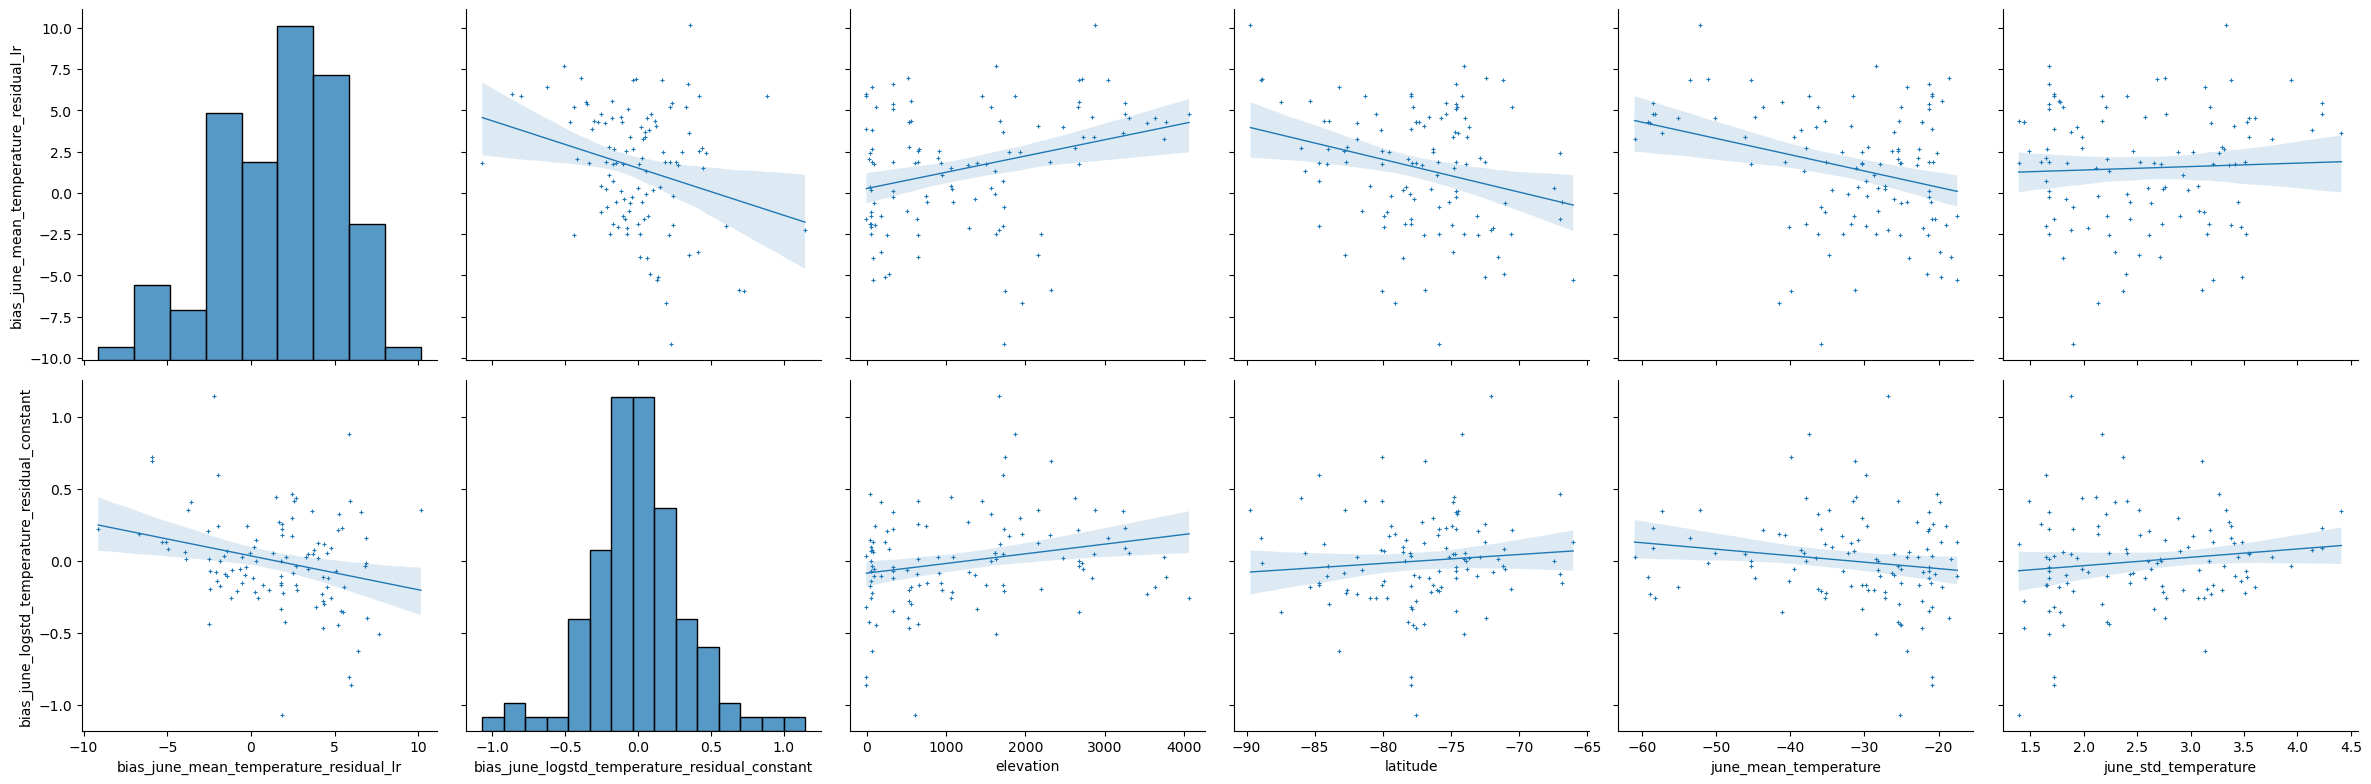

In [17]:
# Transforming data for plotting with seaborn PairGrid 
vars = ['elevation','latitude','june_mean_temperature','june_std_temperature','bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant']
x_vars = ['bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant','elevation','latitude','june_mean_temperature','june_std_temperature']
y_vars = ['bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant']
df_bias_climate = ds_climate_nearest_stacked_filtered[vars].to_dataframe()[vars].reset_index(drop=True)

# Plotting PairGrid with regression lines
g = sns.PairGrid(df_bias_climate, x_vars=x_vars,y_vars=y_vars,height=4,diag_sharey=False)#, corner=True)

reg_kws = {'scatter': False, 'line_kws':{'linewidth':1}}
g.map_offdiag(sns.regplot,**reg_kws)

g.hue_kws = {'marker':['+'],'s':[5],'alpha':[1.0]}
scatter_kws = {'linewidth':0.8}
g.map_offdiag(plt.scatter,**scatter_kws)

hist_kws = {'common_norm':False,'stat':'density'}
g.map_diag(sns.histplot,**hist_kws)

The above pairplot only shows weak relationships between the bias in parameters and the other variables. Therefore, in the model we'll assume the bias is generated from an independent underlying process. 

## Data Preprocessing

The main pre-processing steps we'll do are simply scaling the elevation and latitude predictors and removing any AWS sites with only 2 records for average June temperature. We also define a random subsample of the climate model grid-cells, which we'll use for inference on the parameters of the Gaussian processes in order to reduce the computational demands. Additionally, all the data is transformed away from Xarray and into a dictionary of device arrays (JAX versions of Numpy arrays) of the right shape that the inference package Numpyro expects. 

```{admonition} Computational Complexity and Subsampling:
:class: note, dropdown
While Gaussian processes are extremely useful and flexible, their high computational demand of is often described as their Achilles' heel. Typically, the time for inference scales as the cube of the number of data points, which is a result of taking the inverse of the covariance matrix when computing the likelihood of a set of data for given hyper-parameters. However, there are various methods for improving the speed of inference, such as sparse variational Gaussian processes (SVGPs). These are not utilised in this notebook as they require some additional complexity. Instead we do the sub-optimal procedure of simply only using a subsample of the climate model data for inference. This approach is clearly sub-optimal as it doesn't target the regions of most interest, however, hopefully it'll still produce sensible results and be sufficient for this tutorial example.  
```

```{admonition} Additional Preprocessing:
:class: note, dropdown
Note that some pre-filtering has already been conducted to the data made available for the notebook, such as removing weather stations located on islands and filtering the climate model output to land onlu etc. These steps can be found in the preprocessing.py file of the notebook repository. Additionally, while not done in this notebook, it's important to mention that typically feature engineering is an important component of preprocessing and we could for example derive a distance to the coast predictor. 
```

In [37]:
# Filtering to June records and stations with more than 2 records
aws_june_filter = ds_aws.where(ds_aws['month']==6,drop=True)['t'].data
ds_aws_preprocessed = ds_aws.sel(t=aws_june_filter)
aws_stations_recordsfilter = ds_aws_preprocessed.where(ds_aws_preprocessed['temperature'].count(['t'])>2,drop=True)['station'].data
ds_aws_preprocessed = ds_aws_preprocessed.sel(station=aws_stations_recordsfilter)

climate_june_filter = ds_climate.where(ds_climate['month']==6,drop=True)['time'].data
ds_climate_preprocessed = ds_climate.sel(time=climate_june_filter)
ds_climate_preprocessed = ds_climate_preprocessed.stack(x=('grid_longitude', 'grid_latitude'))
ds_climate_preprocessed = ds_climate_preprocessed.dropna('x')
random_sample = np.random.choice(np.arange(len(ds_climate_preprocessed['x'])), size=100, replace=False)
ds_climate_preprocessed_sample = ds_climate_preprocessed.isel(x=random_sample)

# Scaling latitude and elevation 
lat_scalar = StandardScaler()
ele_scalar = StandardScaler()
ds_aws_preprocessed['latitude_scaled'] = (['station'],  lat_scalar.fit_transform(ds_aws_preprocessed['latitude'].data.reshape(-1,1))[:,0])
ds_aws_preprocessed['elevation_scaled'] = (['station'], ele_scalar.fit_transform(ds_aws_preprocessed['elevation'].data.reshape(-1,1))[:,0])
ds_climate_preprocessed['latitude_scaled'] = (['x'], lat_scalar.transform(ds_climate_preprocessed['latitude'].data.reshape(-1,1))[:,0])
ds_climate_preprocessed['elevation_scaled'] = (['x'], ele_scalar.transform(ds_climate_preprocessed['elevation'].data.reshape(-1,1))[:,0])

# Transforming into dictionary of device arrays
ox = jnp.array(np.dstack([ds_aws_preprocessed['glon'],ds_aws_preprocessed['glat']]))[0]
odata = jnp.array(ds_aws_preprocessed['temperature'].values).transpose()
olat = jnp.array(ds_aws_preprocessed['latitude'].values)
oele = jnp.array(ds_aws_preprocessed['elevation'].values)
olat_scaled = jnp.array(ds_aws_preprocessed['latitude_scaled'].values)
oele_scaled = jnp.array(ds_aws_preprocessed['elevation_scaled'].values)

cx = jnp.array(np.dstack([ds_climate_preprocessed['glon'],ds_climate_preprocessed['glat']]))[0]
cdata = jnp.array(ds_climate_preprocessed.transpose()['temperature'].values).transpose()
clat = jnp.array(ds_climate_preprocessed['latitude'].values)
cele = jnp.array(ds_climate_preprocessed['elevation'].values)
clat_scaled = jnp.array(ds_climate_preprocessed['latitude_scaled'].values)
cele_scaled = jnp.array(ds_climate_preprocessed['elevation_scaled'].values)

cx_subsample = cx[random_sample]
cdata_subsample = cdata[:,random_sample]
cele_subsample = cele[random_sample]
clat_subsample = clat[random_sample]
cele_scaled_subsample = cele_scaled[random_sample]
clat_scaled_subsample = clat_scaled[random_sample]

data_dictionary = {
    'ds_aws_preprocessed':ds_aws_preprocessed,
    'ds_climate_preprocessed':ds_climate_preprocessed,
    'ds_climate_preprocessed_sample':ds_climate_preprocessed_sample,
    'ox':ox,
    'odata':odata,
    'olat':olat,
    'oele':oele,
    'olat_scaled':jnp.array(olat_scaled),
    'oele_scaled':jnp.array(oele_scaled),
    'cx':cx,
    'cdata':cdata,
    'clat':clat,
    'cele':cele,
    'clat_scaled':jnp.array(clat_scaled),
    'cele_scaled':jnp.array(cele_scaled),
    'cx_subsample':cx_subsample,
    'cdata_subsample':cdata_subsample,
    'cele_subsample':cele_subsample,
    'clat_subsample':clat_subsample,
    'cele_scaled_subsample':jnp.array(cele_scaled_subsample),
    'clat_scaled_subsample':jnp.array(clat_scaled_subsample),
    'ele_scaler':ele_scalar,
    'lat_scaler':lat_scalar,
    'random_sample':random_sample,
}

In [38]:
# with open('/home/jez/Bias_Correction_Application/walkthrough_tutorial/data_dictionary_new.pkl', 'wb') as f:
#     pickle.dump(data_dictionary, f)

It's worth plotting the locations of the sampled climate model grid-cells and it's also worth performing a quick sanity check that the data is in the right format:

In [19]:
#Sanity Check

print('Shapes:')
for key in data_dictionary.keys():
    if key not in ['ds_aws_preprocessed','ds_climate_preprocessed','ds_climate_preprocessed_sample','ele_scaler','lat_scaler']:
        print(f'{key} shape: {data_dictionary[key].shape}')

print('\n Values:')
for key in data_dictionary.keys():
    if key not in ['ds_aws_preprocessed','ds_climate_preprocessed','ds_climate_preprocessed_sample','ele_scaler','lat_scaler']:
        if key=='odata':
            print(f'{key} min={np.nanmin(data_dictionary[key]):.1f}, mean={np.nanmean(data_dictionary[key]):.1f}, max={np.nanmax(data_dictionary[key]):.1f}')
        else:
            print(f'{key} min={data_dictionary[key].min():.1f}, mean={data_dictionary[key].mean():.1f}, max={data_dictionary[key].max():.1f}')

print('\n Types:')
for key in data_dictionary.keys():
    print(f'{key} type: {type(data_dictionary[key])}')

Shapes:
ox shape: (156, 2)
odata shape: (42, 156)
olat shape: (156,)
oele shape: (156,)
olat_scaled shape: (156,)
oele_scaled shape: (156,)
cx shape: (5724, 2)
cdata shape: (38, 5724)
clat shape: (5724,)
cele shape: (5724,)
clat_scaled shape: (5724,)
cele_scaled shape: (5724,)
cx_subsample shape: (100, 2)
cdata_subsample shape: (38, 100)
cele_subsample shape: (100,)
clat_subsample shape: (100,)
cele_scaled_subsample shape: (100,)
clat_scaled_subsample shape: (100,)
random_sample shape: (100,)

 Values:
ox min=-24.0, mean=-1.7, max=21.5
odata min=-70.3, mean=-33.4, max=-7.9
olat min=-90.0, mean=-76.4, max=-65.2
oele min=5.0, mean=1246.4, max=4093.0
olat_scaled min=-2.6, mean=-0.0, max=2.1
oele_scaled min=-1.1, mean=0.0, max=2.5
cx min=-24.9, mean=2.5, max=24.4
cdata min=-73.3, mean=-39.6, max=-7.0
clat min=-89.7, mean=-76.6, max=-64.0
cele min=-3.1, mean=2003.6, max=4063.5
clat_scaled min=-2.5, mean=-0.0, max=2.4
cele_scaled min=-1.1, mean=0.7, max=2.5
cx_subsample min=-18.8, mean=3.2, 

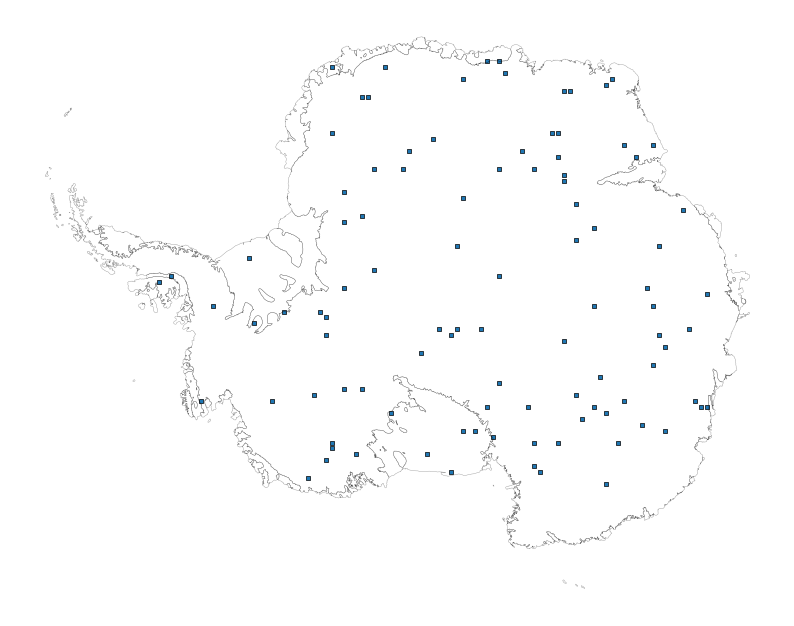

In [20]:
# Plotting the subsample locations
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=100)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_climate_preprocessed_sample['glon'],
    ds_climate_preprocessed_sample['glat'],
    marker='s',
    s=10,
    edgecolor='k',
    linewidths=0.5,
)
plt.show()

## Defining the model

Let $Y(s,t)$ represent the random variable for the June temperature from the AWS data at a particular time and location. Let $Z(s,t)$ represent the equivalent but for the climate model output. We treat the marginal distribution of $Y(s,t)$ and $Z(s,t)$ as Normal, such that $Y(s)\sim \mathcal{N}(\mu_Y(s),\sigma_Y(s))$ and $Z(s)\sim \mathcal{N}(\mu_Z(s),\sigma_Z(s))$. 

To model the spatial covariance in the parameters we use Gaussian processes. A log transformation is applied to the standard deviation ($\tilde{\sigma}=log(\sigma)$) so that it's on the -$\infty,\infty$ sample space of a Gaussian process. Shared latent Gaussian processes are considered between the datasets as well as an independent Gaussian process that generates the bias in the climate model output. The parameters for the climate model are then considered as the sum of an unbiased and biased component $\mu_Z(s)=\mu_Y(s)+\mu_B(s)$ and $\tilde{\sigma}_Z(s)=\tilde{\sigma}_Y(s)+\tilde{\sigma}_B(s)$, where each component is modelled as generated from a Gaussian process. The Gaussian processes are parameterised by a mean function and covariance function. The mean function for $\mu_Y(s)$ is considered linear with respect to elevation and latitude, while for the other parameters it is considered a constant. The covariance function is taken as a Matern3/2 kernel with a lengthscale $l$ and variance $v$.

$$\mu_Y(S) \sim \mathcal{GP}(m_{\mu_Y}(s)|\beta_{\mu_Y},k(s,s'|l_{\mu_Y},v_{\mu_Y}))$$
$$\mu_B(S) \sim \mathcal{GP}(m_{\mu_B},k(s,s'|l_{\mu_B},v_{\mu_B}))$$
$$\tilde{\sigma}_Y(S) \sim \mathcal{GP}(m_{\tilde{\sigma}_Y},k(s,s'|l_{\tilde{\sigma}_Y},v_{\tilde{\sigma}_Y}))$$
$$\tilde{\sigma}_B(S) \sim \mathcal{GP}(m_{\tilde{\sigma}_B},k(s,s'|l_{\tilde{\sigma}_B},v_{\tilde{\sigma}_B}))$$

The plate diagram below shows the relational dependence between the parameters of the model. 

```{admonition} Mean Function and Covariance Function:
:class: note, dropdown
The mean function for the parameter $\mu_Y(s)$ is taken as $m_{\mu_Y}(s)=\beta_{0,\mu_Y} + \beta_{1,\mu_Y} \cdot x_{ele}(s) + \beta_{2,\mu_Y} \cdot x_{lat}(s)$.

The covariance function is taken as a Matern3/2 kernel for each parameter, that is: $k_{M^{3/2}}(s,s')=v\left(1+\dfrac{\sqrt{3}|s-s'|}{l}exp\left({-\dfrac{\sqrt{3}|s-s'|}{l}}\right)\right)$. The distance $|s-s'|$ between points is computed from the 'grid_latitude' and 'grid_longitude' coordinates, which are approximately Euclidean across the domain. The matern3/2 kernel is a popular choice for real-world data applications, see this blog by Andy Jones for some additional info: [The Matérn class of covariance functions
](https://andrewcharlesjones.github.io/journal/matern-kernels.html).
```

![alt text](walkthrough_tutorial/model_diagram.png "Title")

### Splitting up the model for computation

It's quite common when using Gaussian processes to fit the mean function independently of the covariance function. That is to say a mean function is fit to the data initially and then the zero-mean data is fit using the GP implementation that handles covariances between points. There are various reasons for this, such as making the covariance matrix more well-conditioned for inference. 

In this notebook we'll split up the model into a first component estimating the parameters $\mu_Y(s_Y)$, $\mu_Z(s_Z)$, $\tilde{\sigma}_Y(s_Y)$ and $\tilde{\sigma}_Z(s_Z)$ at the AWS and climate model grid cell locations, along with the global parameter values for the mean functions of the latent Gaussian processes $\beta_{0,\mu_Y}$, $\beta_{1,\mu_Y}$, $\beta_{2,\mu_Y}$, $m_{\mu_B}$, $m_{\tilde{\sigma}_Y}$ and $m_{\tilde{\sigma}_B}$. Then the second component will use the residuals $r_{\mu_Y}(s_Y)$, $r_{\mu_Z}(s_Z)$, $r_{\tilde{\sigma}_Y}(s_Y)$ and $r_{\tilde{\sigma}_Z}(s_Z)$ to estimate the parameters of the covariance function for the latent Gaussian processes $l_{\mu_Y}$, $v_{\mu_Y}$, $l_{\mu_B}$, $v_{\mu_B}$, $l_{\tilde{\sigma}_Y}$, $v_{\tilde{\sigma}_Y}$, $l_{\tilde{\sigma}_B}$ and $v_{\tilde{\sigma}_B}$.     

```{admonition} Modelling assumptions and splitting up the model:
:class: note, dropdown
It's important to consider the impact of splitting up the hierarchical model and what assumptions it makes. The main assumption we make is that the noise in $\mu_Y(s_Y)$, $\mu_Z(s_Z)$, $\tilde{\sigma}_Y(s_Y)$ and $\tilde{\sigma}_Z(s_Z)$ is Gaussian, which seems reasonable. However, if we expected the posterior distributions of these parameters to be highly skewed and non-Gaussian then splitting up the model wouldn't adequately capture this and keeping a hierarchical model would better represent the uncertainty in the final predictive distributions. 
```

```{admonition} Model Diagram Component 1: Mean Function:
:class: note, dropdown
![alt text](walkthrough_tutorial/model_diagram_part1.png "Title")
```

```{admonition} Model Diagram Component 2: Residuals and Covariance
:class: note, dropdown
![alt text](walkthrough_tutorial/model_diagram_part2.png "Title")
```

## Parameter Inference 

Inference is performed on the two components of the model separately. To limit the runtime of this notebook, we'll provide the code for running the inference but will perform the actual inference separately and load in the output to examine. The python scripts for running the inference seperately and saving the output are available via the [jupterbook_render branch](https://github.com/Jez-Carter/Bias_Correction_Application/tree/jupyterbook_render) of the repository.  

### Inference on parameters of the mean function

Utilising the Numpyro python package to define the model for component 1:

In [21]:
# The model for predicting the mean and logvar for each dataset as well as the parameters for the meanfunction giving domain-wide behaviour
def meanfunc_model(data_dictionary):
    """
    Function for defining the GP mean function model for the temperature data
    Args:
        data_dictionary (python dictionary): dictionary holding the data needed for the model
    """
    omean_b0 = numpyro.sample("omean_b0",data_dictionary['omean_b0_prior'])
    omean_b1 = numpyro.sample("omean_b1",data_dictionary['omean_b1_prior'])
    omean_b2 = numpyro.sample("omean_b2",data_dictionary['omean_b2_prior'])
    omean_noise = numpyro.sample("omean_noise",data_dictionary['omean_noise_prior'])
    omean_func = omean_b0 + omean_b1*data_dictionary['oele_scaled'] + omean_b2*data_dictionary['olat_scaled']
    omean = numpyro.sample("omean",dist.Normal(omean_func, omean_noise))

    ologvar_b0 = numpyro.sample("ologvar_b0",data_dictionary['ologvar_b0_prior'])
    ologvar_noise = numpyro.sample("ologvar_noise",data_dictionary['ologvar_noise_prior'])
    ologvar_func = ologvar_b0 * jnp.ones(data_dictionary['ox'].shape[0])
    ologvar = numpyro.sample("ologvar",dist.Normal(ologvar_func, ologvar_noise))
    ovar = jnp.exp(ologvar)

    obs_mask = (jnp.isnan(data_dictionary['odata'])==False)
    numpyro.sample("AWS Temperature", dist.Normal(omean, jnp.sqrt(ovar)).mask(obs_mask), obs=data_dictionary["odata"])

    cmean_b0 = numpyro.sample("cmean_b0",data_dictionary['cmean_b0_prior'])
    cmean_noise = numpyro.sample("cmean_noise",data_dictionary['cmean_noise_prior'])
    cmean_func = cmean_b0 + omean_b1*data_dictionary['cele_scaled'] + omean_b2*data_dictionary['clat_scaled']
    cmean = numpyro.sample("cmean",dist.Normal(cmean_func, cmean_noise))

    clogvar_b0 = numpyro.sample("clogvar_b0",data_dictionary['clogvar_b0_prior'])
    clogvar_noise = numpyro.sample("clogvar_noise",data_dictionary['clogvar_noise_prior'])
    clogvar_func = clogvar_b0 * jnp.ones(data_dictionary['cx'].shape[0])
    clogvar = numpyro.sample("clogvar",dist.Normal(clogvar_func, clogvar_noise))
    cvar = jnp.exp(clogvar)

    numpyro.sample("Climate Temperature", dist.Normal(cmean, jnp.sqrt(cvar)), obs=data_dictionary["cdata"])


In the model definition 'omean' represents the mean June temperature estimate at each AWS location, while 'cmean' is the the equivalent for the climate model output at the grid-cell locations. Similarly, 'ologvar' and 'clogvar' represents for the log-variance for each dataset and location respectively. The model follows the following equations: 

$$\mu_Y(s)=m_{\mu_Y}(s)+r_{\mu_Y} \hspace{5em} \mu_Z(s)=m_{\mu_Z}(s)+r_{\mu_Z}$$
$$\tilde{\sigma}_Y(s)=m_{\tilde{\sigma}_Y}(s)+r_{\tilde{\sigma}_Y} \hspace{5em} \tilde{\sigma}_Z(s)=m_{\tilde{\sigma}_Z}(s)+r_{\tilde{\sigma}_Z}$$
$$m_{\mu_Y}(s)=\beta_{0,\mu_Y} + \beta_{1,\mu} \cdot x_{ele}(s) + \beta_{2,\mu} \cdot x_{lat}(s)$$
$$m_{\mu_Z}(s)=\beta_{0,\mu_Z} + \beta_{1,\mu} \cdot x_{ele}(s) + \beta_{2,\mu} \cdot x_{lat}(s)$$
<!-- $$r_{\mu_Y}(s)\sim\mathcal{N}(0,n_{\mu_Y})$$
$$r_{\mu_Y}(s)\sim\mathcal{N}(0,n_{\mu_Y})$$ -->

Defining a function for running the Bayesian inference on the model parameters given the data:

In [22]:
# A function to run inference on the model
def run_inference(
    model, rng_key, num_warmup, num_samples, num_chains, *args, **kwargs
):
    """
    Helper function for doing MCMC inference
    Args:
        model (python function): function that follows numpyros syntax
        rng_key (np array): PRNGKey for reproducible results
        num_warmup (int): Number of MCMC steps for warmup
        num_samples (int): Number of MCMC samples to take of parameters after warmup
        num_chains (int): Number of chains to run in parallel (or sequentially without GPU)
        *args: Additional arguments to pass to the model
        **kwargs: Additional keyword arguments to pass to the model
        distance_matrix_values(jax device array): matrix of distances between sites, shape [#sites,#sites]
    Returns:
        MCMC numpyro instance (class object): An MCMC class object with functions such as .get_samples() and .run()
    """
    starttime = timeit.default_timer()

    kernel = NUTS(model)
    mcmc = MCMC(
        kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
    )

    mcmc.run(rng_key, *args, **kwargs)

    mcmc.print_summary()
    print("Time Taken:", timeit.default_timer() - starttime)
    return mcmc

As we're utilising a Bayesian framework, we'll have to define some prior distributions for the parameters. While in theory the prior distribution should represent our state of knowledge before observing the data and so if we have no additional knowledge should be fully non-informative, in practice it's common to at least set sensible bounds using the exploratory analysis to limit the complexity of the inference space. Here, we compute some basic metrics, which we then use to help set sensible priors.  

In [23]:
print('Useful Metrics for Priors: \n',
      f"""mean odata:
      min={np.nanmin(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      mean={np.nanmean(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      max={np.nanmax(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      var={np.nanvar(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      \n""",
      f"""logvar odata:
      min={np.nanmin(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      mean={np.nanmean(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      max={np.nanmax(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      var={np.nanvar(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      \n""",
      f"""mean cdata:
      min={np.nanmin(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      mean={np.nanmean(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      max={np.nanmax(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      var={np.nanvar(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      \n""",
      f"""logvar cdata:
      min={np.nanmin(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      mean={np.nanmean(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      max={np.nanmax(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      var={np.nanvar(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      \n""",
)

Useful Metrics for Priors: 
 mean odata:
      min=-65.0,
      mean=-33.4,
      max=-13.4,
      var=155.0,
      
 logvar odata:
      min=-4.9,
      mean=1.7,
      max=4.1,
      var=1.1,
      
 mean cdata:
      min=-62.8,
      mean=-39.6,
      max=-12.6,
      var=154.6,
      
 logvar cdata:
      min=0.6,
      mean=2.1,
      max=3.3,
      var=0.2,
      



In [24]:
# Setting priors
data_dictionary.update({
    "omean_b0_prior": dist.Normal(-33.0, 10.0),
    "omean_b1_prior": dist.Normal(0.0, 10.0),
    "omean_b2_prior": dist.Normal(0.0, 10.0),
    "omean_noise_prior": dist.Uniform(1e-2, 10.0),
    "ologvar_b0_prior": dist.Normal(5, 5.0),
    "ologvar_noise_prior": dist.Uniform(1e-3, 2.0),
})

data_dictionary.update({
    "cmean_b0_prior": dist.Normal(-39.0, 10.0),
    "cmean_noise_prior": dist.Uniform(1e-2, 10.0),
    "clogvar_b0_prior": dist.Normal(5, 2.0),
    "clogvar_noise_prior": dist.Uniform(1e-3, 2.0),
})

The code for running the inference and saving estimates of the parameter posterior distributions is given below. Note that the code is commented out as instead of running the inference within this notebook, for computational reasons we'll simply load in the output. The output is saved using the ArViZ package, which handles inference data from lots of different probabilisitic programming packages and can be used to produce nice summary metrics and plots. 

In [32]:
'''
# %% Running inference
mcmc = run_inference(meanfunc_model, rng_key, 1000, 2000,4, data_dictionary)

idata = az.from_numpyro(mcmc,
                coords={
                "station": data_dictionary['ds_aws_preprocessed']['station'],
                "x": data_dictionary['ds_climate_preprocessed']['x'],
    },
                dims={"clogvar": ["x"],
                      "cmean": ["x"],
                      "ologvar": ["station"],
                      "omean": ["station"],})
meanfunc_posterior = idata.posterior


# Computing the residuals from the mean function model parameters
meanfunc_posterior = meanfunc_posterior.assign_coords({'oele_scaled':('station', data_dictionary['oele_scaled']),
                        'olat_scaled':('station', data_dictionary['olat_scaled']),
                        'cele_scaled':('x', data_dictionary['cele_scaled']),
                        'clat_scaled':('x', data_dictionary['clat_scaled'])})
meanfunc_posterior['omean_func'] = meanfunc_posterior['omean_b0']+meanfunc_posterior['omean_b1']*meanfunc_posterior['oele_scaled']+meanfunc_posterior['omean_b2']*meanfunc_posterior['olat_scaled']
meanfunc_posterior['cmean_func'] = meanfunc_posterior['cmean_b0']+meanfunc_posterior['omean_b1']*meanfunc_posterior['cele_scaled']+meanfunc_posterior['omean_b2']*meanfunc_posterior['clat_scaled']
meanfunc_posterior['ologvar_func'] = meanfunc_posterior['ologvar_b0']
meanfunc_posterior['clogvar_func'] = meanfunc_posterior['clogvar_b0']
meanfunc_posterior['omean_func_residual'] = meanfunc_posterior['omean']-meanfunc_posterior['omean_func']
meanfunc_posterior['cmean_func_residual'] = meanfunc_posterior['cmean']-meanfunc_posterior['cmean_func']
meanfunc_posterior['ologvar_func_residual'] = meanfunc_posterior['ologvar']-meanfunc_posterior['ologvar_func']
meanfunc_posterior['clogvar_func_residual'] = meanfunc_posterior['clogvar']-meanfunc_posterior['clogvar_func']

data_dictionary['meanfunc_posterior'] = meanfunc_posterior
'''

with open('/home/jez/Bias_Correction_Application/walkthrough_tutorial/data_dictionary.pkl', 'rb') as f:
    data_dictionary = pickle.load(f)

meanfunc_posterior = data_dictionary['meanfunc_posterior'] 


/home/jez/miniconda3/envs/jbook_BCA/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


MCMC is an approximate procedure and it is difficult to assess directly whether the samples returned from the inference accurately capture the true posterior distributions of the parameters. The effective sample size (ESS) and r_hat diagonostics provide some indication, we're looking for values of r_hat in the range (1.0, 1.05) and ESS that are comparable to the total number of samples, which we get in this run:

In [26]:
az.summary(meanfunc_posterior[['omean_b0',
            'omean_b1',
            'omean_b2',
            'omean_noise',
            'ologvar_b0',
            'ologvar_noise',
            'cmean_b0',
            'cmean_noise',
            'clogvar_b0',
            ]],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omean_b0,-33.427,0.538,-34.507,-32.400,0.005,0.003,12208.0,6100.0,1.0
omean_b1,-9.653,0.364,-10.384,-8.957,0.004,0.003,9882.0,6581.0,1.0
omean_b2,2.272,0.382,1.514,3.020,0.003,0.002,11987.0,5646.0,1.0
omean_noise,6.687,0.395,5.939,7.466,0.004,0.003,9233.0,5215.0,1.0
ologvar_b0,2.043,0.066,1.912,2.170,0.001,0.001,4334.0,5317.0,1.0
ologvar_noise,0.584,0.064,0.463,0.710,0.001,0.001,2349.0,4263.0,1.0
cmean_b0,-33.185,0.563,-34.340,-32.126,0.006,0.004,9869.0,6152.0,1.0
cmean_noise,5.271,0.385,4.579,6.061,0.004,0.003,10785.0,5511.0,1.0
clogvar_b0,2.216,0.043,2.131,2.299,0.001,0.000,6882.0,6119.0,1.0


### Inference on parameters of the residual and covariance functions

For component 2 of the model, the residuals of the mean and log(standard dev.) are treated as independent and so for simplicity we only show the code defining the model for the residual of the mean $r_{\mu_Y}(s)$ and $r_{\mu_Z}(s)$. Again utilising the Numpyro python package to define the model gives:

In [27]:
# Helper functions to be used in the residual model

def diagonal_noise(coord, noise):
    return jnp.diag(jnp.full(coord.shape[0], noise))

def generate_obs_conditional_climate_dist(
    ox, cx, cdata, ckernel, cdiag, okernel, odiag
):
    y2 = cdata
    u1 = jnp.full(ox.shape[0], 0)
    u2 = jnp.full(cx.shape[0], 0)
    k11 = okernel(ox, ox) + diagonal_noise(ox, odiag)
    k12 = okernel(ox, cx)
    k21 = okernel(cx, ox)
    k22 = ckernel(cx, cx) + diagonal_noise(cx, cdiag)
    k22i = jnp.linalg.inv(k22)
    u1g2 = u1 + jnp.matmul(jnp.matmul(k12, k22i), y2 - u2)
    l22 = jnp.linalg.cholesky(k22)
    l22i = jnp.linalg.inv(l22)
    p21 = jnp.matmul(l22i, k21)
    k1g2 = k11 - jnp.matmul(p21.T, p21)
    mvn_dist = dist.MultivariateNormal(u1g2, k1g2)
    return mvn_dist

# The residual model for the mean temperature

def residual_model_mean(data_dictionary):
    """
    Example model where the residual of the mean for the climate data is generated from 2 GPs,
    one of which also generates the observations and one of which generates bias in the climate model.
    """
    meanfunc_posterior = data_dictionary['meanfunc_posterior']
    omean_func_residual_exp = meanfunc_posterior['omean_func_residual'].mean(['draw','chain']).data
    omean_func_residual_var = meanfunc_posterior['omean_func_residual'].var(['draw','chain']).data
    cmean_func_residual_exp_subsample = meanfunc_posterior['cmean_func_residual'].isel(x=data_dictionary['random_sample']).mean(['draw','chain']).data
    
    kern_var = numpyro.sample("kern_var", data_dictionary['omean_func_residual_kvprior'])
    lengthscale = numpyro.sample("lengthscale", data_dictionary['omean_func_residual_klprior'])
    kernel = kern_var * kernels.Matern32(lengthscale,L2Distance())
    noise = numpyro.sample("noise", data_dictionary['omean_func_residual_nprior'])
    var_obs = omean_func_residual_var
    
    bkern_var = numpyro.sample("bkern_var", data_dictionary['bmean_func_residual_kvprior'])
    blengthscale = numpyro.sample("blengthscale", data_dictionary['bmean_func_residual_klprior'])
    bkernel = bkern_var * kernels.Matern32(blengthscale,L2Distance())
    bnoise = numpyro.sample("bnoise", data_dictionary['bmean_func_residual_nprior'])

    ckernel = kernel + bkernel
    cnoise = noise + bnoise 
    cgp = GaussianProcess(ckernel, data_dictionary["cx_subsample"], diag=cnoise, mean=0)
    numpyro.sample("climate_temperature",
                   cgp.numpyro_dist(),
                   obs=cmean_func_residual_exp_subsample)

    obs_conditional_climate_dist = generate_obs_conditional_climate_dist(
        data_dictionary["ox"],
        data_dictionary["cx_subsample"],
        cmean_func_residual_exp_subsample,
        ckernel,
        cnoise,
        kernel,
        var_obs+noise
    )
    numpyro.sample(
        "obs_temperature",
        obs_conditional_climate_dist,
        obs=omean_func_residual_exp
    )

# Function for running the MCMC inference and generating the posterior distributions for the model

def generate_posterior_residual_model_mean(data_dictionary,
                                    rng_key,
                                    num_warmup,
                                    num_samples,
                                    num_chains):
    mcmc_residual_model_mean = run_inference(
        residual_model_mean,
        rng_key,
        num_warmup,
        num_samples,
        num_chains,
        data_dictionary,
    )
    idata_residual_model_mean = az.from_numpyro(mcmc_residual_model_mean)
    data_dictionary["idata_residual_model_mean"] = idata_residual_model_mean

In the model definition for the residuals the observations are the expectations of the residuals computed from inference of the meanfunction model in component 1. That is $E[r_{\mu_Y}(s_Y)]$ and $E[r_{\mu_Z}(s_Z)]$. The uncertainty in these values is captured through the variance, so $V[r_{\mu_Y}(s_Y)]$ and $V[r_{\mu_Z}(s_Z)]$. Although, we don't include $V[r_{\mu_Z}(s_Z)]$ in the model definition as it's an insignificant quantity. The model follows the equations:

$$r_{\mu_Y}(s) \sim \mathcal{GP}(0|,k(s,s'|l_{\mu_Y},v_{\mu_Y},n_{\mu_Y})) \hspace{2em} r_{\mu_B}(s) \sim \mathcal{GP}(0|,k(s,s'|l_{\mu_B},v_{\mu_B},n_{\mu_B}))$$

$$r_{\mu_Z}(s) = r_{\mu_Y}(s)+r_{\mu_B}(s)$$

$$k(s,s')=v(1+\dfrac{\sqrt{3}|s-s'|}{l}exp\left({-\dfrac{\sqrt{3}|s-s'|}{l}}\right)$$

```{admonition} Function 'generate_obs_conditional_climate_dist':
:class: note, dropdown
The function 'generate_obs_conditional_climate_dist' is defined as the parameters of $\mathcal{GP}(0|,k(s,s'|l_{\mu_Y},v_{\mu_Y},n_{\mu_Y}))$ and $\mathcal{GP}(0|,k(s,s'|l_{\mu_B},v_{\mu_B},n_{\mu_B}))$ are conditional on both $r_{\mu_Y}(s_Y)$ and $r_{\mu_Z}(s_Z)$. So we generate a distribution for the probability of the unbiased AWS data given the already conditioned on climate model data.  
```

Again choosing sensible priors for the parameters of the model that have reasonable bounds based on some basic summary metrics:

In [28]:
# Useful metrics for priors
exp_omean_func_residual = meanfunc_posterior['omean_func_residual'].mean(['draw','chain'])
ox_ranges = data_dictionary['ox'].max(axis=0)-data_dictionary['ox'].min(axis=0)
print('Useful Metrics for Priors: \n',
      f"""
      Mean Obs:
      min={exp_omean_func_residual.min():.1f},
      mean={exp_omean_func_residual.mean():.1f},
      max={exp_omean_func_residual.max():.1f},
      var={exp_omean_func_residual.var():.1f},
      """,
      f'\n Obs Axis Ranges={ox_ranges}'
)

Useful Metrics for Priors: 
 
      Mean Obs:
      min=-17.0,
      mean=-0.0,
      max=16.9,
      var=42.2,
       
 Obs Axis Ranges=[45.47068137 34.36497791]


In [29]:
# Setting priors
lengthscale_max = 20

data_dictionary['omean_func_residual_kvprior'] = dist.Uniform(0.1,100.0)
data_dictionary['omean_func_residual_klprior'] = dist.Uniform(1,lengthscale_max)
data_dictionary['omean_func_residual_nprior'] = dist.Uniform(0.1,20.0)

data_dictionary['bmean_func_residual_kvprior'] = dist.Uniform(0.1,100.0)
data_dictionary['bmean_func_residual_klprior'] = dist.Uniform(1,lengthscale_max)
data_dictionary['bmean_func_residual_nprior'] = dist.Uniform(0.1,20.0)

The code for running the inference and saving estimates of the parameter posterior distributions is given below. Note that the code is commented out as instead of running the inference within this notebook, for computational reasons we'll simply load in the output. 

In [30]:
# Running the inference
'''
generate_posterior_residual_model_mean(data_dictionary,
                                rng_key,
                                1000,
                                1000,
                                4)
'''

with open('/home/jez/Bias_Correction_Application/walkthrough_tutorial/data_dictionary.pkl', 'rb') as f:
    data_dictionary = pickle.load(f)

idata_residual_model_mean = data_dictionary["idata_residual_model_mean"]


In [31]:
az.summary(idata_residual_model_mean.posterior,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bkern_var,9.901,9.807,0.139,27.480,0.206,0.151,2914.0,2274.0,1.0
blengthscale,14.087,4.209,6.159,19.999,0.073,0.054,2800.0,1890.0,1.0
bnoise,0.937,0.841,0.100,2.626,0.013,0.010,3027.0,1737.0,1.0
kern_var,37.062,9.573,22.317,56.631,0.248,0.200,2273.0,1412.0,1.0
lengthscale,3.211,0.623,2.080,4.427,0.015,0.011,1848.0,1669.0,1.0
noise,5.591,1.233,3.329,8.132,0.024,0.017,2496.0,2571.0,1.0


The posterior distributions for the parameters of the model appear sensible on first glance. The r-hat statistic indicates that the chains are independent as desired and the effective sample size is of comparable magnitude to the total number of samples taken. 

### Making posterior predictive estimates of the unbiased mean and variance across the domain

From the previous section we have:
- Posterior estimates of the mean and log-variance at the AWS sites and climate model grid cells, that is $\mu_Y(s_Y)$, $\tilde{\sigma}_Y(s_Y)$, $\mu_Z(s_Z)$ and $\tilde{\sigma}_Z(s_Z)$. As well as the estimates for the meanfunction and residual components: $m_{\mu_Y}(s_Y)$, $m_{\tilde{\sigma}_Y}(s_Y)$, $m_{\mu_Z}(s_Z)$, $m_{\tilde{\sigma}_Z}(s_Z)$ and $r_{\mu_Y}(s_Y)$, $r_{\tilde{\sigma}_Y}(s_Y)$, $r_{\mu_Z}(s_Z)$ and $r_{\tilde{\sigma}_Z}(s_Z)$.
- Posterior estimates of the parameters of the mean functions, so $\beta_{0,\mu_Y}$, $\beta_{1,\mu}$, $\beta_{2,\mu}$, $\beta_{0,\mu_Z}$, $\beta_{0,\tilde{\sigma}_Y}$ and $\beta_{0,\tilde{\sigma}_Z}$.
- Posterior estimates of the parameters of the covariance functions, so $l_{\mu_Y}$, $v_{\mu_Y}$, $n_{\mu_Y}$, $l_{\mu_B}$, $v_{\mu_B}$ and $n_{\mu_B}$.

Now we want to make estimates of the posterior distributions of the unbiased mean and log-variance at the climate model locations to use for bias correction, so $\mu_Y(s_Z)$ and $\tilde{\sigma}_Y(s_Z)$. This is known as the posterior predictive and involves conditioning on both the inferred parameters of the model and the observed data. Since we split up the hierarchical model, to get $\mu_Y(s_Z)$ and $\tilde{\sigma}_Y(s_Z)$ we'll get estimates for $m_{\mu_Y}(s_Z)$ and $m_{\tilde{\sigma}_Y}(s_Z)$ from the first component of the model, then $r_{\mu_Y}(s_Z)$ and $r_{\tilde{\sigma}_Y}(s_Z)$ from the second component.

```{admonition} Posterior predictive calculation:
:class: note, dropdown
Let the collection of parameters for the model be:
$\phi = [m_{\mu_Y}(s_Y), m_{\mu_Z}(s_Z), r_{\mu_Y}(s_Y), r_{\mu_Z}(s_Z),
\beta_{0,\mu_Y}, \beta_{1,\mu}, \beta_{2,\mu}, \beta_{0,\mu_Z},
l_{\mu_Y}, v_{\mu_Y}, n_{\mu_Y}, l_{\mu_B}, v_{\mu_B}, n_{\mu_B}]$

Then the posterior predictive distributions is given by:

$$p(\mu_Y(\hat{s})|Y(s_Y),Z(s_Z))=$$

$$\int 
p(m_{\mu_Y}(\hat{s})|\beta_{0,\mu_Y}, \beta_{1,\mu}, \beta_{2,\mu}, \beta_{0,\mu_Z})
\cdot 
p(r_{\mu_Y}(\hat{s})|r_{\mu_Y}(s_Y), r_{\mu_Z}(s_Z),l_{\mu_Y}, v_{\mu_Y}, n_{\mu_Y}, l_{\mu_B}, v_{\mu_B}, n_{\mu_B})
\cdot
p(\theta|Y(s_Y),Z(s_Z)) d\theta$$

Where $p(m_{\mu_Y}(\hat{s})|\beta_{0,\mu_Y}, \beta_{1,\mu}, \beta_{2,\mu}, \beta_{0,\mu_Z})$ is the predictive distribution of the meanfunction and $p(r_{\mu_Y}(\hat{s})|r_{\mu_Y}(s_Y), r_{\mu_Z}(s_Z),l_{\mu_Y}, v_{\mu_Y}, n_{\mu_Y}, l_{\mu_B}, v_{\mu_B}, n_{\mu_B})$ is the predictive distribution of the residual function. The distribution $p(\theta|Y(s_Y),Z(s_Z))$ is simply the posterior distribution for the parameters of our model, which we get samples from using MCMC. 

To get samples of $\mu_Y(\hat{s})$ from the posterior predictive distribution we take samples from the predictive distribution of the meanfunction and the predictive distribution of the residual using parameters sampled from the posterior. That is for each sample from our MCMC inference, we define the predictive distributions and then take a sample.  
```

In [40]:
with open('/home/jez/Bias_Correction_Application/walkthrough_tutorial/data_dictionary_new.pkl', 'rb') as f:
    data_dictionary_new = pickle.load(f)

/home/jez/miniconda3/envs/jbook_BCA/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Sampling the predictive distribution of the mean function is simple: 

In [ ]:
meanfunc_postpredictive_parameters = ['omean_b0','omean_b1','omean_b2']
meanfunc_postpredictive = data_dictionary["meanfunc_posterior"][meanfunc_postpredictive_parameters]
meanfunc_posterior['unbiased_meanfunc_predictive'] = (meanfunc_posterior['omean_b0']+
                                                           meanfunc_posterior['omean_b1']*meanfunc_posterior['cele_scaled']+
                                                           meanfunc_posterior['omean_b2']*meanfunc_posterior['clat_scaled'])

Sampling the predictive distribution of the residual is more difficult and we construct some functions to help.

In [74]:
# %% Defining function for generating posterior predictive realisations of the residuals

def generate_truth_predictive_dist_mean(nx, data_dictionary, posterior_param_realisation):
    kern_var_realisation = posterior_param_realisation["kern_var_realisation"]
    lengthscale_realisation = posterior_param_realisation["lengthscale_realisation"]
    noise_realisation = posterior_param_realisation["noise_realisation"]

    bkern_var_realisation = posterior_param_realisation["bkern_var_realisation"]
    blengthscale_realisation = posterior_param_realisation["blengthscale_realisation"]
    bnoise_realisation = posterior_param_realisation["bnoise_realisation"]

    meanfunc_posterior = data_dictionary['meanfunc_posterior']
    omean_func_residual_exp = meanfunc_posterior['omean_func_residual'].mean(['draw','chain']).data
    omean_func_residual_var = meanfunc_posterior['omean_func_residual'].var(['draw','chain']).data
    cmean_func_residual_exp = meanfunc_posterior['cmean_func_residual'].mean(['draw','chain']).data

    ox = data_dictionary["ox"]
    cx = data_dictionary["cx"]
    odata = omean_func_residual_exp
    odata_var = omean_func_residual_var
    cdata = cmean_func_residual_exp
    kernelo = kern_var_realisation * kernels.Matern32(lengthscale_realisation,L2Distance())
    kernelb = bkern_var_realisation * kernels.Matern32(blengthscale_realisation,L2Distance())

    noise = noise_realisation + odata_var
    bnoise = bnoise_realisation
    cnoise = noise_realisation + bnoise

    jitter = 1e-5

    y2 = jnp.hstack([odata, cdata])
    u1 = jnp.full(nx.shape[0], 0)
    u2 = jnp.hstack(
        [jnp.full(ox.shape[0], 0), jnp.full(cx.shape[0], 0)]
    )
    k11 = kernelo(nx, nx) + diagonal_noise(nx, jitter)
    k12 = jnp.hstack([kernelo(nx, ox), kernelo(nx, cx)])
    k21 = jnp.vstack([kernelo(ox, nx), kernelo(cx, nx)])
    k22_upper = jnp.hstack(
        [kernelo(ox, ox) + diagonal_noise(ox, noise), kernelo(ox, cx)]
    )
    k22_lower = jnp.hstack(
        [
            kernelo(cx, ox),
            kernelo(cx, cx) + kernelb(cx, cx) + diagonal_noise(cx, cnoise),
        ]
    )
    k22 = jnp.vstack([k22_upper, k22_lower])
    k22 = k22
    k22i = jnp.linalg.inv(k22)

    u1g2 = u1 + jnp.matmul(jnp.matmul(k12, k22i), y2 - u2)
    k1g2 = k11 - jnp.matmul(jnp.matmul(k12, k22i), k21)
    mvn = dist.MultivariateNormal(u1g2, k1g2)
    return mvn


def generate_posterior_predictive_realisations_dualprocess_mean(
    nx,
    data_dictionary,
    num_parameter_realisations,
    num_posterior_pred_realisations,
    rng_key
):
    posterior = data_dictionary["idata_residual_model_mean"].posterior
    truth_posterior_predictive_realisations = []
    iteration = 0
    for i in tqdm(np.random.randint(posterior.draw.shape, size=num_parameter_realisations)):
        posterior_param_realisation = {
            "iteration": i,
            "kern_var_realisation": posterior["kern_var"].data[0, :][i],
            "lengthscale_realisation": posterior["lengthscale"].data[0, :][i],
            "noise_realisation": posterior["noise"].data[0, :][i],
            "bkern_var_realisation": posterior["bkern_var"].data[0, :][i],
            "blengthscale_realisation": posterior["blengthscale"].data[0, :][i],
            "bnoise_realisation": posterior["bnoise"].data[0, :][i],
        }

        truth_predictive_dist = generate_truth_predictive_dist_mean(
            nx, data_dictionary, posterior_param_realisation
        )
        iteration += 1

        truth_predictive_realisations = truth_predictive_dist.sample(
            rng_key, sample_shape=(num_posterior_pred_realisations,)
        )
        rng_key, rng_key_ = random.split(rng_key)

        truth_posterior_predictive_realisations.append(truth_predictive_realisations)

    truth_posterior_predictive_realisations = jnp.array(
        truth_posterior_predictive_realisations
    )

    residual_pospred_ds = xr.Dataset(
    coords = {'hyperparameter_draws':range(num_parameter_realisations),
              'gp_draws':range(num_posterior_pred_realisations),
              'nx':range(len(nx)),
              },
    data_vars = {'unbiased_mean_residual_postpred':(['hyperparameter_draws','gp_draws','nx'], truth_posterior_predictive_realisations),
                }
    )
    return residual_pospred_ds


Generating the residual posterior predictive samples:

In [76]:
# Generating posterior predictive realisations of the residuals
residual_postpred = generate_posterior_predictive_realisations_dualprocess_mean(
    data_dictionary["cx"],
    data_dictionary,
    100,
    5,
    rng_key
)

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Computing the expectations and uncertainties:

In [79]:
unbiased_meanfunc_predictive_exp = meanfunc_postpredictive.mean(['draw','chain'])['unbiased_meanfunc_predictive']
unbiased_meanfunc_predictive_var = meanfunc_postpredictive.var(['draw','chain'])['unbiased_meanfunc_predictive']

residual_postpred_exp = residual_postpred.mean(['gp_draws','hyperparameter_draws'])
residual_postpred_var = residual_postpred.var(['gp_draws','hyperparameter_draws'])

<xarray.DataArray 'unbiased_meanfunc_predictive' (cx_whole: 5724)> Size: 46kB
Array([-25.047113  , -23.22933811, -23.69891625, ..., -18.4898046 ,
       -18.20454335, -18.25322313], dtype=float64)
Coordinates:
  * cx_whole           (cx_whole) int64 46kB 0 1 2 3 4 ... 5720 5721 5722 5723
    cele_whole         (cx_whole) float64 46kB ...
    clat_whole         (cx_whole) float64 46kB ...
    cele_scaled_whole  (cx_whole) float64 46kB ...
    clat_scaled_whole  (cx_whole) float64 46kB ...